# Bankruptcy Prediction Models

---
### Success Criteria for Bankruptcy Prediction Models

Predicting corporate bankruptcy is a high-stakes, imbalanced classification task where the cost of false negatives (missing a bankrupt firm) is often much higher than false positives. Therefore, success criteria must reflect both statistical performance and domain relevance.

**Summary of Success Criteria**

| Metric     | Competitive Threshold | Ideal Target |
|------------|-----------------------|--------------|
| F1-score   | >= 0.60               | >= 0.70      |
| Recall     | >= 0.70               | >= 0.80      |
| Precision  | >= 0.60               | >= 0.75      |
| ROC AUC    | >= 0.95               | >= 0.97      |


#### Key Performance Metrics

1. **F1-Score (≥ 0.60 is competitive)**
- Balances precision and recall, especially important in imbalanced datasets.
- Studies show that F1-scores between **0.60 and 0.75** are typical for bankruptcy prediction using machine learning models.
- *Reference*: [Predicting Bankruptcy Using Machine Learning Techniques – IEEE Access (2020)](https://ieeexplore.ieee.org/document/9099060)

2. **Recall (≥ 0.70 is strong)**
- Measures the ability to correctly identify bankrupt firms.
- High recall is crucial to minimize missed bankruptcies, which can have severe financial consequences.
- *Reference*: [Bankruptcy Prediction Using SMOTE and Ensemble Learning – Expert Systems with Applications (2021)](https://www.sciencedirect.com/science/article/pii/S0957417421000273)

3. **Precision (≥ 0.60 is desirable)**
- Indicates how many predicted bankruptcies are actually correct.
- Important for avoiding unnecessary interventions or false alarms.
- *Reference*: [A Comparative Study of Bankruptcy Prediction Models – Journal of Risk and Financial Management (2022)](https://www.mdpi.com/1911-8074/15/2/72)

4. **ROC AUC (≥ 0.95 is excellent)**
- Measures the model’s ability to rank bankrupt vs. non-bankrupt firms.
- AUC values above 0.95 indicate strong discriminatory power.
- *Reference*: [Machine Learning for Bankruptcy Prediction: A Systematic Review – Applied Sciences (2021)](https://www.mdpi.com/2076-3417/11/3/1127)

---

## 1. Data Loading & Exploratory Data Analysis (EDA)

### 1.1 Load the Dataset

Loaded the Taiwan Economic Journal dataset containing 6,819 instances and 96 financial features. The target variable is binary: 1 for bankrupt, 0 for non-bankrupt.



In [1]:
from datetime import datetime
from dotenv import load_dotenv
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from tqdm import tqdm
from xgboost import XGBClassifier
from xgboost import plot_importance
import heapq
import joblib
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import xgboost as xgb

#import tensorflow as tf
#import torch

**Ensure reproducibility across entire pipeline**

In [2]:
np.random.seed(42)
random.seed(42)
#tf.random.set_seed(42)
#torch.manual_seed(42)
random_state=42

In [3]:
# Load environment variables
load_dotenv()

# Get data directories from .env
raw_dir = os.getenv("DATA_RAW")
processed_dir = os.getenv("DATA_PROCESSED")
final_dir = os.getenv("DATA_FINAL")
models_dir = os.getenv("MODELS_DIR")
reports_dir = os.getenv("REPORTS_DIR")
src_dir = os.getenv("SRC_DIR")
experiments_dir = os.getenv("EXPERIMENTS_DIR")

# Build the full path to data.csv
csv_path = os.path.join(raw_dir, "data.csv")

# Read the CSV
df_original = pd.read_csv(csv_path)

### 1.2 Inspect the Data Structure

In [4]:
# Show full column width, all columns and all rows
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [5]:
"""
Check the shape, column names, and data types
"""

print(f"Dataset Shape: {df_original.shape}\n")
print(df_original.info())

Dataset Shape: (6819, 96)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   floa

### 1.3 Feature Name Cleaning<br>a. Rules and Justifications

This table outlines the transformations applied to feature names in the dataset, explaining why each change is necessary and providing examples of affected columns.

| Rule | Reason for Change | Example Before | Example After |
|------|-------------------|----------------|---------------|
| **Remove leading/trailing spaces** | Prevents invisible mismatches and indexing errors | ' Total Assets ' | Total_Assets |
| **Replace % with pct** | % is a special character in formulas and queries; pct is clearer and safer | 'Profit %' | Profit_pct |
| **Replace / with  over** | / can break parsing or be misinterpreted as division | 'Revenue / Cost' | Revenue_over_Cost |
| **Replace - with _** | - is treated as a subtraction operator in formulas | 'Net-Income' | Net_Income |
| **Remove ? symbol** | ? can break queries and is rarely needed in feature names | 'Bankrupt?' | Bankrupt |
| **Replace 'Yuan ¥' with 'Yuan'** | ¥ is a non-ASCII symbol that causes encoding issues | 'Revenue in Yuan ¥' | Revenue_in_Yuan |
| **Replace ( with _** | ( is used for grouping in formulas and regex; replacing preserves structure | 'ROA(C)' | ROA_C | 
| **Remove )** | Closing bracket without its pair is confusing and breaks parsing | 'ROA(C)' | ROA_C |
| **Replace spaces with _** | Spaces break syntax in most modeling tools and APIs | 'Debt Ratio' | Debt_Ratio |
| **Collapse multiple underscores** | Avoids messy names from repeated replacements

In [6]:
def custom_clean_column_names(df):
    """
    Cleans DataFrame column names using custom rules:
    - Remove leading/trailing spaces
    - Replace '%' with 'pct'
    - Replace '/' with ' over '
    - Replace '-' with '_'
    - Remove '?' symbol
    - Replace 'Yuan ¥' with 'Yuan'
    - Replace '(' with '_'
    - Remove ')'
    - Replace spaces with '_'
    - Collapse multiple underscores
    """
    
    df_cleaned = df.copy()     # Create a copy to avoid modifying original   
    cleaned = []
    for col in df.columns:
        col = col.strip()                      # Remove leading/trailing spaces
        col = col.replace('%', 'pct')          # Replace % with pct
        col = col.replace('/', ' over ')       # Replace / with over
        col = col.replace('-', '_')            # Replace - with _
        col = col.replace('?', '')             # Remove ?
        col = col.replace('Yuan ¥', 'Yuan')    # Remove ¥
        col = col.replace("'", '')             # Remove '
        col = col.replace('(', '_')            # Replace ( with _
        col = col.replace(')', '')             # Remove )
        col = re.sub(r'\s+', '_', col)         # Replace spaces with _
        col = re.sub(r'_+', '_', col)          # Collapse multiple underscores
        cleaned.append(col)
    df_cleaned.columns = cleaned
    return df_cleaned

df_bank = custom_clean_column_names(df_original)

In [7]:
# Compare original and cleaned column names side by side
for original, cleaned in zip(df_original.columns, df_bank.columns):
    print(f"{original:<40} ->  {cleaned}")

Bankrupt?                                ->  Bankrupt
 ROA(C) before interest and depreciation before interest ->  ROA_C_before_interest_and_depreciation_before_interest
 ROA(A) before interest and % after tax  ->  ROA_A_before_interest_and_pct_after_tax
 ROA(B) before interest and depreciation after tax ->  ROA_B_before_interest_and_depreciation_after_tax
 Operating Gross Margin                  ->  Operating_Gross_Margin
 Realized Sales Gross Margin             ->  Realized_Sales_Gross_Margin
 Operating Profit Rate                   ->  Operating_Profit_Rate
 Pre-tax net Interest Rate               ->  Pre_tax_net_Interest_Rate
 After-tax net Interest Rate             ->  After_tax_net_Interest_Rate
 Non-industry income and expenditure/revenue ->  Non_industry_income_and_expenditure_over_revenue
 Continuous interest rate (after tax)    ->  Continuous_interest_rate_after_tax
 Operating Expense Rate                  ->  Operating_Expense_Rate
 Research and development expense rate   ->

### 1.3 Feature Name Cleaning<br>b. Validate Integer Columns for Outlier Analysis

- Examine columns values and distribution to decide whether they should be part of the IQR-based analysis.

In [8]:
def summarize_int64_columns(df):
    """
    Prints unique values and their percentage distribution for each int64 column.
    """
    int64_cols = df.select_dtypes(include='int64').columns

    for col in int64_cols:
        print(f"\nCOLUMN: {col}")
        value_counts = df[col].value_counts(dropna=False)
        percentages = df[col].value_counts(normalize=True, dropna=False) * 100
        summary = pd.DataFrame({'COUNT': value_counts, 'PERCENTAGE (%)': percentages.round(2)})
        print(summary)

summarize_int64_columns(df_bank)



COLUMN: Bankrupt
          COUNT  PERCENTAGE (%)
Bankrupt                       
0          6599           96.77
1           220            3.23

COLUMN: Liability_Assets_Flag
                       COUNT  PERCENTAGE (%)
Liability_Assets_Flag                       
0                       6811           99.88
1                          8            0.12

COLUMN: Net_Income_Flag
                 COUNT  PERCENTAGE (%)
Net_Income_Flag                       
1                 6819           100.0


### 1.3 Feature Name Cleaning<br>c. Exclusion of int64 Columns from Outlier Analysis

| Column Name               | Value Distribution                     | Reason for Exclusion                                      |
|--------------------------|----------------------------------------|------------------------------------------------------------|
| Bankrupt              | 96.77% vs 0, 3.23%                   | Binary target variable; not a feature for outlier detection |
| Liability_Assets_Flag  | 99.88% vs 0, 0.12%                   | Binary indicator; extremely imbalanced, not continuous      |
| Net_Income_Flag        | 100%                                | Constant value; no outliers possible |


### 1.4 Check for Missing Values

In [9]:
"""
Missing Data Check:
    missing_values_column: the count of missing values per feature column.
    total_missing: aggregates all missing values across the dataset.
    if "Any missing values is 0, there are no missing values in any column.
"""
          
missing_values_column = df_bank.isnull().sum()
total_missing = missing_values_column.sum()

if total_missing == 0:
    print("No missing values detected. Dataset is complete.")
else:
    print(f"Total Missing Values: {total_missing}")
    print(missing_values_column[missing_values_column > 0])


No missing values detected. Dataset is complete.


This ensures that no imputation or row removal is necessary, and we can proceed directly to scaling and feature selection during preprocessing.

### 1.5 Summary Statistics

In [10]:
df_bank.describe()

Bankrupt  ROA_C_before_interest_and_depreciation_before_interest  \
count  6819.000000                                             6819.000000   
mean      0.032263                                                0.505180   
std       0.176710                                                0.060686   
min       0.000000                                                0.000000   
25%       0.000000                                                0.476527   
50%       0.000000                                                0.502706   
75%       0.000000                                                0.535563   
max       1.000000                                                1.000000   

       ROA_A_before_interest_and_pct_after_tax  \
count                              6819.000000   
mean                                  0.558625   
std                                   0.065620   
min                                   0.000000   
25%                                   0.535543   
50%                                   0.559802   
75%                                   0.589157   
max                                   1.000000   

       ROA_B_before_interest_and_depreciation_after_tax  \
count                                       6819.000000   
mean                                           0.553589   
std                                            0.061595   
min                                            0.000000   
25%                                            0.527277   
50%                                            0.552278   
75%                                            0.584105   
max                                            1.000000   

       Operating_Gross_Margin  Realized_Sales_Gross_Margin  \
count             6819.000000                  6819.000000   
mean                 0.607948                     0.607929   
std                  0.016934                     0.016916   
min                  0.000000                     0.000000   
25%                  0.600445                     0.600434   
50%                  0.605997                     0.605976   
75%                  0.613914                     0.613842   
max                  1.000000                     1.000000   

       Operating_Profit_Rate  Pre_tax_net_Interest_Rate  \
count            6819.000000                6819.000000   
mean                0.998755                   0.797190   
std                 0.013010                   0.012869   
min                 0.000000                   0.000000   
25%                 0.998969                   0.797386   
50%                 0.999022                   0.797464   
75%                 0.999095                   0.797579   
max                 1.000000                   1.000000   

       After_tax_net_Interest_Rate  \
count                  6819.000000   
mean                      0.809084   
std                       0.013601   
min                       0.000000   
25%                       0.809312   
50%                       0.809375   
75%                       0.809469   
max                       1.000000   

       Non_industry_income_and_expenditure_over_revenue  \
count                                       6819.000000   
mean                                           0.303623   
std                                            0.011163   
min                                            0.000000   
25%                                            0.303466   
50%                                            0.303525   
75%                                            0.303585   
max                                            1.000000   

       Continuous_interest_rate_after_tax  Operating_Expense_Rate  \
count                         6819.000000            6.819000e+03   
mean                             0.781381            1.995347e+09   
std                              0.012679            3.237684e+09   
min                              0.000000            0.000000e+00   
25%          

## 2. Feature Distribution Analysis

### 2.1 Outlier Detection<br>a. Apply IQR rule

In [11]:
def flag_extreme_features(df, iqr_multiplier=1.5):
    """
    Identifies features with extreme min or max values using the IQR rule,
    analyzing only float64 columns (excluding int64).

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        iqr_multiplier (float): Multiplier for IQR to define extreme thresholds.

    Returns:
        summary (pd.DataFrame): Summary statistics.
        display_cols (pd.DataFrame): Filtered view of extreme features.
        counts (dict): Count of extreme min, max, and total flagged features.
        iqr_features (list): List of columns included in IQR analysis.
    """

    # Step 1: Select only float64 columns for IQR analysis
    df_numeric = df.select_dtypes(include='float64')
    iqr_features = df_numeric.columns.tolist()

    # Step 2: Get summary statistics
    summary = df_numeric.describe().T

    # Step 3: Calculate IQR and range
    iqr = summary['75%'] - summary['25%']
    summary['range'] = summary['max'] - summary['min']

    # Step 4: Flag extreme min and max values using IQR rule
    summary['extreme_min'] = summary['min'] < (summary['25%'] - iqr_multiplier * iqr)
    summary['extreme_max'] = summary['max'] > (summary['75%'] + iqr_multiplier * iqr)

    # Step 5: Filter only features with extreme values
    extreme_features = summary[(summary['extreme_min']) | (summary['extreme_max'])]

    # Step 6: Display relevant columns
    display_cols = extreme_features[['min', 'max', 'range', 'extreme_min', 'extreme_max']]

    # Step 7: Count how many features are flagged
    counts = {
        'extreme_min': int(summary['extreme_min'].sum()),
        'extreme_max': int(summary['extreme_max'].sum()),
        'total_extreme': int(extreme_features.shape[0])
    }

    return summary, display_cols, counts, iqr_features

In [12]:
summary, display_cols, counts, iqr_features = flag_extreme_features(df_bank)

print(f"IQR-analyzed features: {iqr_features}\n")
print(f"COUNTS: {counts}\n")
print("EXTREME FEATURES SUMMARY:")
display_cols

IQR-analyzed features: ['ROA_C_before_interest_and_depreciation_before_interest', 'ROA_A_before_interest_and_pct_after_tax', 'ROA_B_before_interest_and_depreciation_after_tax', 'Operating_Gross_Margin', 'Realized_Sales_Gross_Margin', 'Operating_Profit_Rate', 'Pre_tax_net_Interest_Rate', 'After_tax_net_Interest_Rate', 'Non_industry_income_and_expenditure_over_revenue', 'Continuous_interest_rate_after_tax', 'Operating_Expense_Rate', 'Research_and_development_expense_rate', 'Cash_flow_rate', 'Interest_bearing_debt_interest_rate', 'Tax_rate_A', 'Net_Value_Per_Share_B', 'Net_Value_Per_Share_A', 'Net_Value_Per_Share_C', 'Persistent_EPS_in_the_Last_Four_Seasons', 'Cash_Flow_Per_Share', 'Revenue_Per_Share_Yuan', 'Operating_Profit_Per_Share_Yuan', 'Per_Share_Net_profit_before_tax_Yuan', 'Realized_Sales_Gross_Profit_Growth_Rate', 'Operating_Profit_Growth_Rate', 'After_tax_Net_Profit_Growth_Rate', 'Regular_Net_Profit_Growth_Rate', 'Continuous_Net_Profit_Growth_Rate', 'Total_Asset_Growth_Rate', 'N

min           max  \
ROA_C_before_interest_and_depreciation_before_interest  0.0  1.000000e+00   
ROA_A_before_interest_and_pct_after_tax                 0.0  1.000000e+00   
ROA_B_before_interest_and_depreciation_after_tax        0.0  1.000000e+00   
Operating_Gross_Margin                                  0.0  1.000000e+00   
Realized_Sales_Gross_Margin                             0.0  1.000000e+00   
Operating_Profit_Rate                                   0.0  1.000000e+00   
Pre_tax_net_Interest_Rate                               0.0  1.000000e+00   
After_tax_net_Interest_Rate                             0.0  1.000000e+00   
Non_industry_income_and_expenditure_over_revenue        0.0  1.000000e+00   
Continuous_interest_rate_after_tax                      0.0  1.000000e+00   
Research_and_development_expense_rate                   0.0  9.980000e+09   
Cash_flow_rate                                          0.0  1.000000e+00   
Interest_bearing_debt_interest_rate                     0.0  9.900000e+08   
Tax_rate_A                                              0.0  1.000000e+00   
Net_Value_Per_Share_B                                   0.0  1.000000e+00   
Net_Value_Per_Share_A                                   0.0  1.000000e+00   
Net_Value_Per_Share_C                                   0.0  1.000000e+00   
Persistent_EPS_in_the_Last_Four_Seasons                 0.0  1.000000e+00   
Cash_Flow_Per_Share                                     0.0  1.000000e+00   
Revenue_Per_Share_Yuan                                  0.0  3.020000e+09   
Operating_Profit_Per_Share_Yuan                         0.0  1.000000e+00   
Per_Share_Net_profit_before_tax_Yuan                    0.0  1.000000e+00   
Realized_Sales_Gross_Profit_Growth_Rate                 0.0  1.000000e+00   
Operating_Profit_Growth_Rate                            0.0  1.000000e+00   
After_tax_Net_Profit_Growth_Rate                        0.0  1.000000e+00   
Regular_Net_Profit_Growth_Rate                          0.0  1.000000e+00   
Continuous_Net_Profit_Growth_Rate                       0.0  1.000000e+00   
Total_Asset_Growth_Rate                                 0.0  9.990000e+09   
Net_Value_Growth_Rate                                   0.0  9.330000e+09   
Total_Asset_Return_Growth_Rate_Ratio                    0.0  1.000000e+00   
Cash_Reinvestment_pct                                   0.0  1.000000e+00   
Current_Ratio                                           0.0  2.750000e+09   
Quick_Ratio                                             0.0  9.230000e+09   
Interest_Expense_Ratio                                  0.0  1.000000e+00   
Total_debt_over_Total_net_worth                         0.0  9.940000e+09   
Debt_ratio_pct                                          0.0  1.000000e+00   
Net_worth_over_Assets                                   0.0  1.000000e+00   
Long_term_fund_suitability_ratio_A                      0.0  1.000000e+00   
Borrowing_dependency                                    0.0  1.000000e+00   
Contingent_liabilities_over_Net_worth                   0.0  1.000000e+00   
Operating_profit_over_Paid_in_capital                   0.0  1.000000e+00   
Net_profit_before_tax_over_Paid_in_capital              0.0  1.000000e+00   
Inventory_and_accounts_receivable_over_Net_value        0.0  1.000000e+00   
Total_Asset_Turnover                                    0.0  1.000000e+00   
Accounts_Receivable_Turnover                            0.0  9.740000e+09   
Average_Collection_Days                                 0.0  9.730000e+09   
Fixed_Assets_Turnover_Frequency                         0.0  9.990000e+09   
Net_Worth_Turnover_Rate_times                           0.0  1.000000e+00   
Revenue_per_person                                      0.0  8.810000e+09   
Operating_profit_per_person                             0.0  1.000000e+00   
Allocation_rate_per_person                              0.0  9.570000e+09   
Working_Capital_to_Total_Assets                     

### 2.1 Outlier Detection<br>b. Feature distribution plot with IQR thresholds

In [13]:
# Boxplot with IQR Thresholds
import matplotlib.pyplot as plt
import seaborn as sns

def plot_extreme_boxplots_with_thresholds(df, features, plots_per_row=3, iqr_multiplier=1.5):
    total = len(features)
    rows = (total + plots_per_row - 1) // plots_per_row

    fig, axes = plt.subplots(rows, plots_per_row, figsize=(5 * plots_per_row, 4 * rows))
    axes = axes.flatten()

    for i, col in enumerate(features):
        # Calculate IQR thresholds
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR

        # Plot boxplot
        sns.boxplot(x=df[col], ax=axes[i], color='skyblue')
        axes[i].axvline(lower_bound, color='red', linestyle='--', label='Lower Bound')
        axes[i].axvline(upper_bound, color='green', linestyle='--', label='Upper Bound')
        axes[i].set_title(f'{col}', fontsize=9)

        # Optional: add legend only to first plot
        if i == 0:
            axes[i].legend()

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

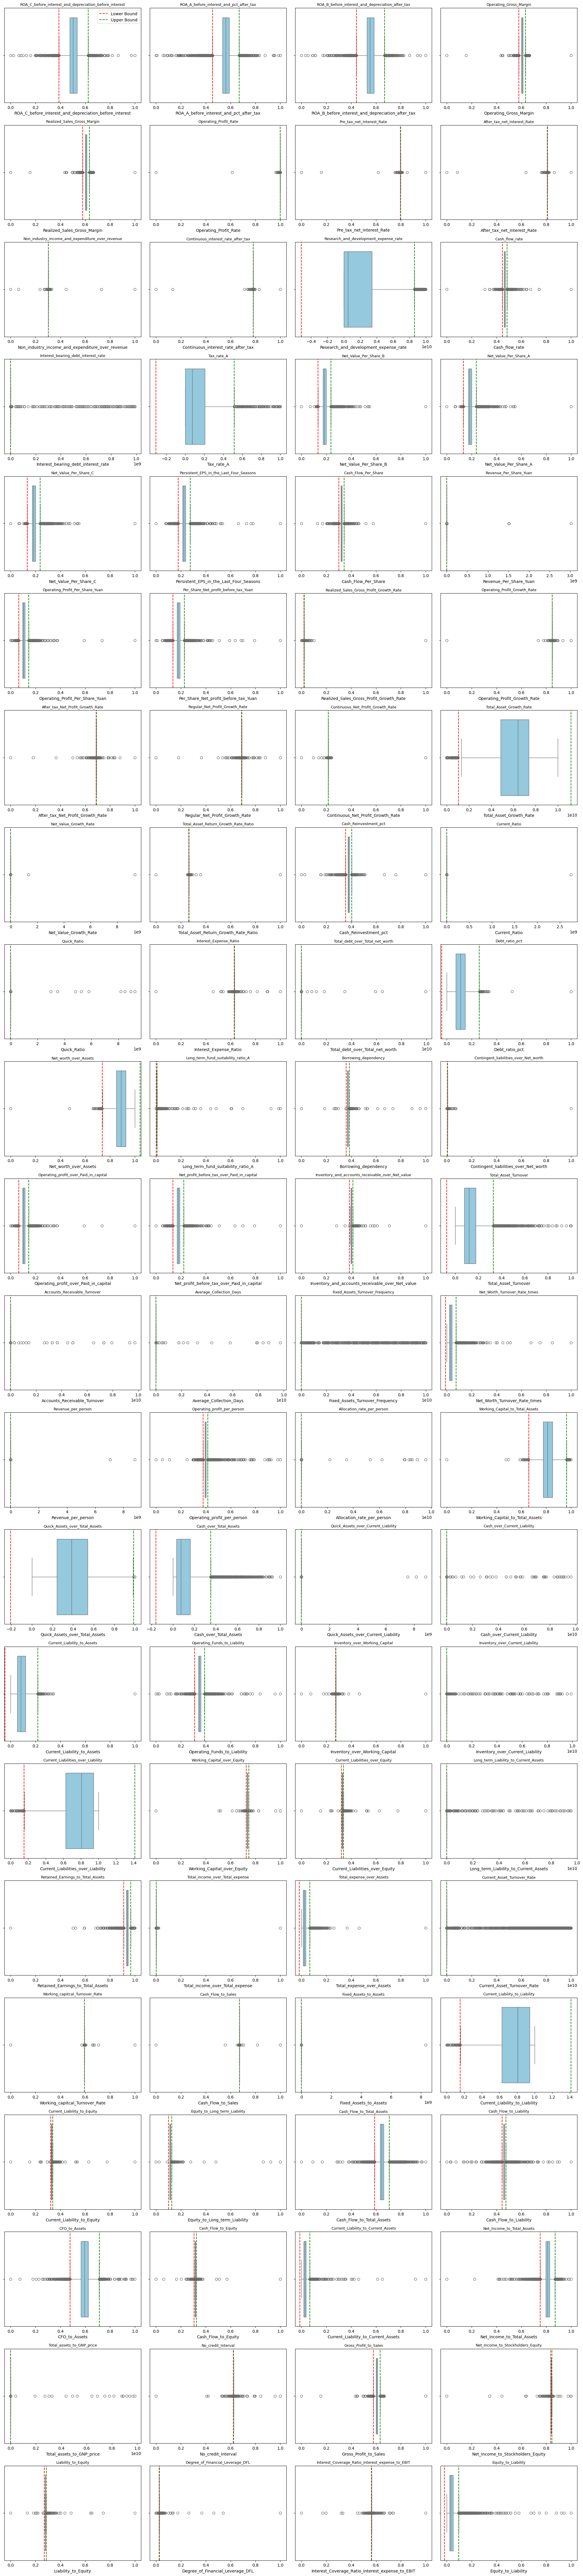

In [14]:
extreme_features = summary[(summary['extreme_min']) | (summary['extreme_max'])].index.tolist()
plot_extreme_boxplots_with_thresholds(df_bank, extreme_features, plots_per_row=4, iqr_multiplier=1.5)

### 2.1 Outlier Detection<br>c. Feature distribution histogram plot

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_extreme_feature_histograms_with_iqr(df, extreme_features, iqr_multiplier=1.5):
    """
    Plots histograms for extreme features with IQR thresholds overlaid.
    
    Parameters:
        df (pd.DataFrame): The dataset
        extreme_features (list): List of column names flagged as extreme
    """
    
    cols = 4
    rows = (len(extreme_features) + cols - 1) // cols
    plt.figure(figsize=(5 * cols, 4 * rows))

    for i, feature in enumerate(extreme_features):
        data = df[feature].dropna()
        q1 = data.quantile(0.25)
        q3 = data.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - iqr_multiplier * iqr
        upper_bound = q3 + iqr_multiplier * iqr

        plt.subplot(rows, cols, i + 1)
        sns.histplot(data, bins=30, kde=False, color='steelblue')
        plt.axvline(lower_bound, color='red', linestyle='--', label='Lower IQR Bound')
        plt.axvline(upper_bound, color='green', linestyle='--', label='Upper IQR Bound')
        plt.title(feature)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.legend()

    plt.tight_layout()
    plt.show()

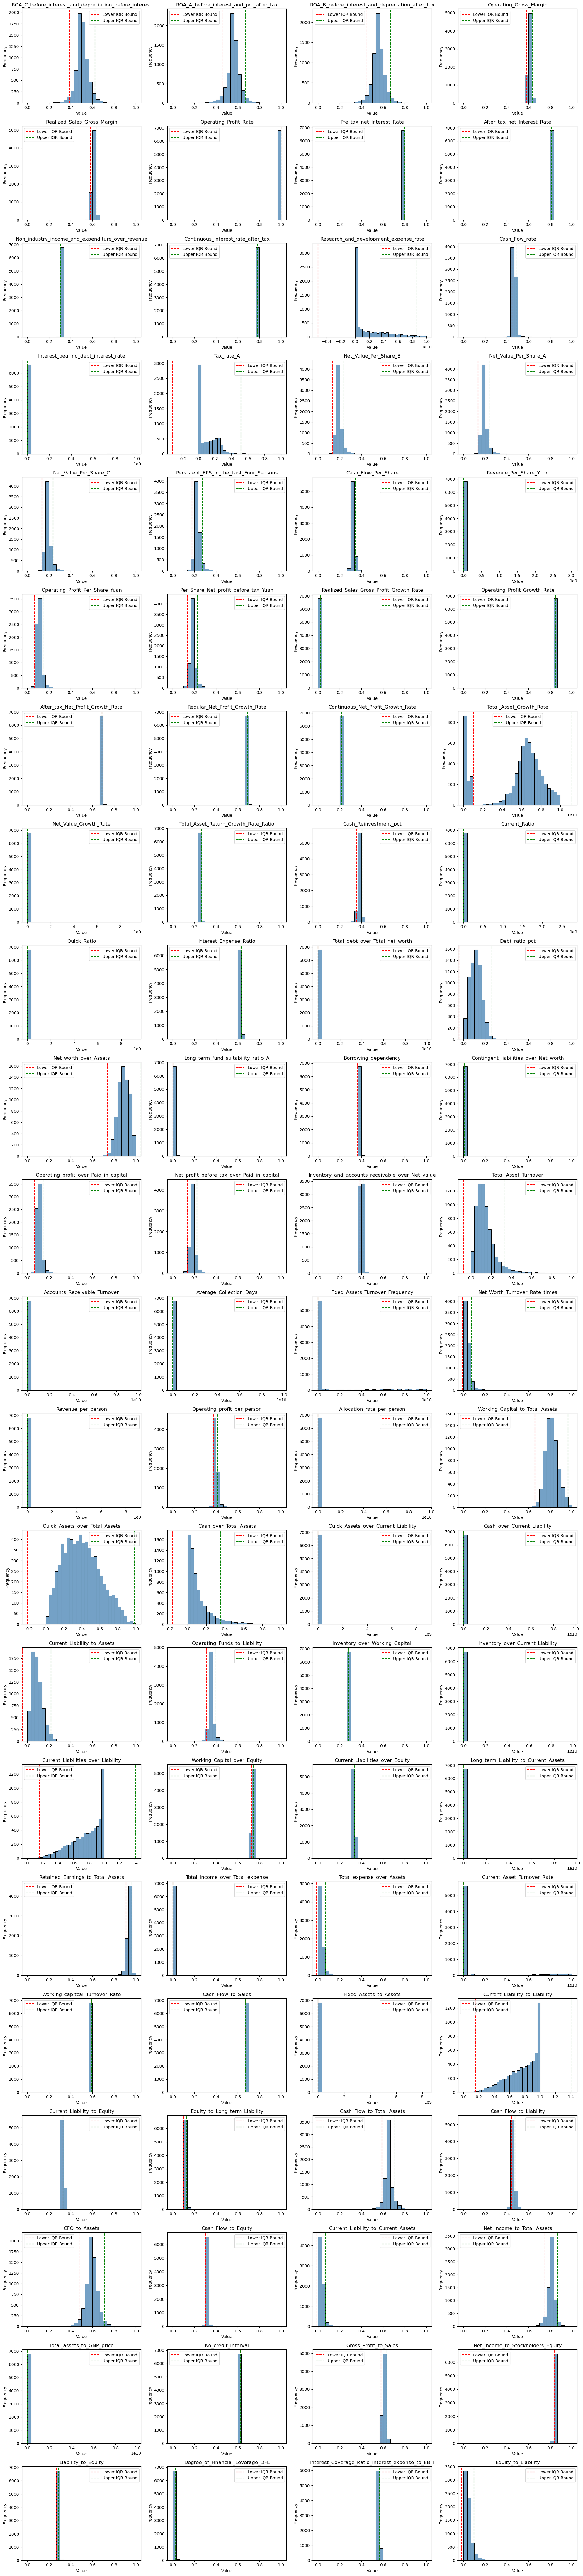

In [16]:
plot_extreme_feature_histograms_with_iqr(df_bank, extreme_features, iqr_multiplier=1.5)

### 2.2 Outlier Summary<br>a. Count of extrem features

This section summarizes the count of extreme outliers detected using the IQR method across selected features.

| Metric           | Count |
|------------------|-------|
| **IQR multiplier**| 1.5 |
| **Extreme Min**  | 60    |
| **Extreme Max**  | 84    |
| **Total Extreme**| 88    |
| **Total Features Evaluated** | 93 |
| **Extreme Features Ratio**| 94.6% |

### 2.2 Outlier Summary<br>b. Log transformation assessment

Identify candidate features for log transformation if the column meets 2 condiitions:
1. df[col].min() > 0: The column must have all positive values (log transformation is undefined for 0 or negative values).
2. df[col].skew() > 1: The column must be right-skewed, meaning it has a long tail on the right and could benefit from log transformation to normalize its distribution.

In [17]:
log_candidates = [
    col for col in df_bank.columns
    if df_bank[col].min() > 0 and df_bank[col].skew() > 1
]
log_candidates

[]

This returned an empty list, indicating no features met both conditions.

In [18]:
extreme_with_zero_min = [col for col in extreme_features if df_bank[col].min() <= 0]
print(f"Number of extreme features with min ≤ 0: {len(extreme_with_zero_min)}")
print("\nOutput: columns with min ≤ 0")
[col for col in extreme_features if df_bank[col].min() <= 0]

Number of extreme features with min ≤ 0: 88

Output: columns with min ≤ 0


['ROA_C_before_interest_and_depreciation_before_interest',
 'ROA_A_before_interest_and_pct_after_tax',
 'ROA_B_before_interest_and_depreciation_after_tax',
 'Operating_Gross_Margin',
 'Realized_Sales_Gross_Margin',
 'Operating_Profit_Rate',
 'Pre_tax_net_Interest_Rate',
 'After_tax_net_Interest_Rate',
 'Non_industry_income_and_expenditure_over_revenue',
 'Continuous_interest_rate_after_tax',
 'Research_and_development_expense_rate',
 'Cash_flow_rate',
 'Interest_bearing_debt_interest_rate',
 'Tax_rate_A',
 'Net_Value_Per_Share_B',
 'Net_Value_Per_Share_A',
 'Net_Value_Per_Share_C',
 'Persistent_EPS_in_the_Last_Four_Seasons',
 'Cash_Flow_Per_Share',
 'Revenue_Per_Share_Yuan',
 'Operating_Profit_Per_Share_Yuan',
 'Per_Share_Net_profit_before_tax_Yuan',
 'Realized_Sales_Gross_Profit_Growth_Rate',
 'Operating_Profit_Growth_Rate',
 'After_tax_Net_Profit_Growth_Rate',
 'Regular_Net_Profit_Growth_Rate',
 'Continuous_Net_Profit_Growth_Rate',
 'Total_Asset_Growth_Rate',
 'Net_Value_Growth_Rate'

### 2.2 Outlier Summary<br>c. Outlier and transformation strategy

- The dataset contains 93 float64 features, of which **88 (~95%)** were flagged as extreme using IQR-based thresholds.
- All 88 extreme features have a **minimum value of 0**, making them **unsuitable for log transformation**.
- These features are retained in full, as they may contain meaningful signals related to bankruptcy risk.
- To mitigate the influence of outliers while preserving interpretability, we apply **Robust Scaling** to all float64 features.

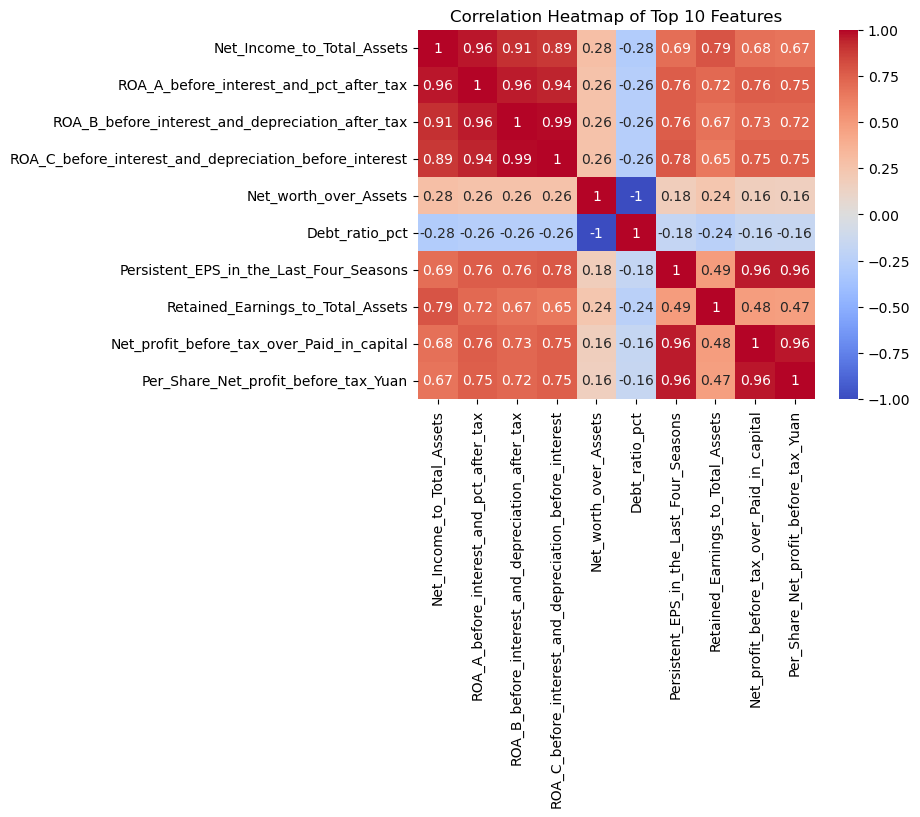

In [19]:
# Compute correlations
corr_matrix = df_bank.corr()
top_corr_features = corr_matrix['Bankrupt'].abs().sort_values(ascending=False)[1:11].index

# Plot heatmap
sns.heatmap(df_bank[top_corr_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Top 10 Features')
plt.show()

### 3.1 Target Variable Countplot

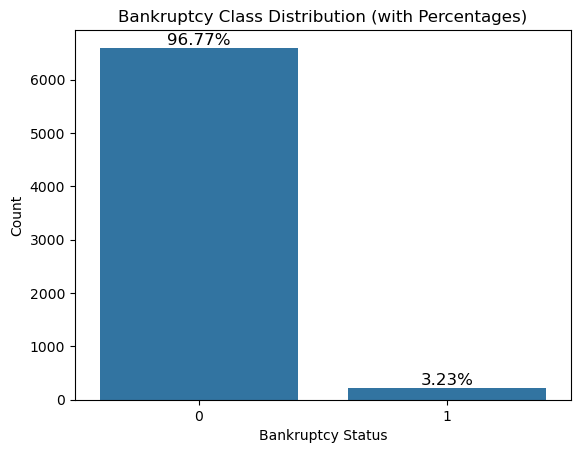

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

target = df_bank['Bankrupt']

# Calculate percentages
total = len(df_bank)
percentages = target.value_counts(normalize=True) * 100

# Create bar plot
ax = sns.countplot(x=target, data=df_bank)

# Annotate bars with percentages
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.2f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=12)

plt.title('Bankruptcy Class Distribution (with Percentages)')
plt.xlabel('Bankruptcy Status')
plt.ylabel('Count')
plt.show()

### 3.2 Implications for Modeling

Bankruptcy cases represent only 3.23% of the dataset, confirming a severe class imbalance. This imbalance has several important implications for our modeling approach:

1. Metric Selection Traditional accuracy is misleading in imbalanced settings. A model that predicts all cases as non-bankrupt would still achieve over 96% accuracy but offer no real value. Therefore, we will prioritize metrics that reflect performance on the minority class:

-   Accuracy: Not an effective metric here
    -   Misleading as even a model always predicts "non-bankrupt" still gets 96% accuracy
-   Precision: How many predicted bankruptcies were actually bankrupt

- Recall: How many actual bankruptcies were correctly predicted

- F1-score:
    - Penalizing models that ignore the minority class
    - Rewarding models that find a good balance between catching bankruptcies and avoiding false alarms

- ROC-AUC: Overall ability to distinguish between classes

2. Resampling Techniques To address the imbalance, we will experiment with:

- Oversampling (e.g., SMOTE) to synthetically boost minority class

- Undersampling to reduce majority class dominance

- Hybrid methods that combine both

3. Model Sensitivity Some models (e.g., decision trees, ensemble methods) are more robust to imbalance, while others (e.g., logistic regression) may require class weighting or resampling to perform well.

4. Cross-Validation Strategy We will use stratified sampling during train/test splits and cross-validation to ensure that each fold maintains the original class proportions.

## 4. Preprocessing

### 4.1 Feature Selection
- Drop Net_Income_Flag (constant)
- Retain Liability_Assets_Flag (binary int64)
- Separate Bankrupt as target variable

    **Results**
    - `X`: Feature matrix containing 93 scaled float64 financial ratios and 1 binary flag (`Liability_Assets_Flag`)
    - `y`: Target variable indicating bankruptcy status  
        - `1` → Bankrupt  
        - `0` → Non-bankrupt

    These variables will be used for model training, validation, and testing throughout the pipeline.


In [21]:
X = df_bank.drop(columns=["Bankrupt", "Net_Income_Flag"])
y = df_bank["Bankrupt"]

### 4.2 Scaling Strategy with Reproducibility

- Use RobustScaler for float64 features (based on outlier analysis in Section 2)
- RobustScaler scale features using statistics that are robust to outliers
- Reattach Liability_Assets_Flag after scaling
- Save scaled features for reuse

Use unit_variance=True if:

- using models sensitive to feature scale (e.g., SVM, KNN, PCA).
- want features to have comparable influence based on variance.
- apply PCA and want components to reflect standardized variance.

Tree-Based Models (e.g., Random Forest, XGBoost)
- These models are not sensitive to feature scale or variance:
    - RobustScaler(unit_variance=False) to handle outliers without forcing unit variance.

Linear Models (e.g., Logistic Regression, SVM, PCA)
- These models are sensitive to feature scale and variance:
    - RobustScaler(unit_variance=True) to ensure features have comparable influence.

**Input sets to models**
- X_tree_scaled for tree-based models
- X_linear_scaled for linear models

In [22]:
# Get directory paths from .env
# processed_dir = os.getenv("DATA_PROCESSED")
# models_dir = os.getenv("MODELS_DIR")
# reports_dir = os.getenv("REPORTS_DIR")

# Step 1: Scale Float64 Features with Two Scalers
prediction_features = X.select_dtypes("float64")

# Tree-based scaler
scaler_tree = RobustScaler(unit_variance=False)
X_tree_scaled = pd.DataFrame(scaler_tree.fit_transform(prediction_features), columns=prediction_features.columns)

# Linear-based scaler
scaler_linear = RobustScaler(unit_variance=True)
X_linear_scaled = pd.DataFrame(scaler_linear.fit_transform(prediction_features), columns=prediction_features.columns)

# Step 2: Reattach Liability_Assets_Flag
X_tree_scaled["Liability_Assets_Flag"] = X["Liability_Assets_Flag"].values
X_linear_scaled["Liability_Assets_Flag"] = X["Liability_Assets_Flag"].values

# Step 3: Save Scaled Feature Sets and Scalers
joblib.dump(X_tree_scaled, os.path.join(processed_dir, "X_tree_scaled.pkl"))
joblib.dump(X_linear_scaled, os.path.join(processed_dir, "X_linear_scaled.pkl"))

joblib.dump(scaler_tree, os.path.join(models_dir, "scaler_tree.pkl"))
joblib.dump(scaler_linear, os.path.join(models_dir, "scaler_linear.pkl"))

# Step 4: Document Metadata
scaling_metadata = {
    "tree_model_scaler": "RobustScaler(unit_variance=False)",
    "linear_model_scaler": "RobustScaler(unit_variance=True)",
    "features_scaled": list(prediction_features.columns),
    "binary_flag": "Liability_Assets_Flag",
    "random_state": random_state
}

with open(os.path.join(reports_dir, "scaling_metadata.json"), "w") as f:
    json.dump(scaling_metadata, f, indent=4)


### 4.3 Data Splitting Strategy

Split scaled feature sets into:
- Training set: for model fitting (80%)
- Validation set: for tuning and comparison (10%)
- Test set: for final evaluation (10%)


To keep the modeling pipeline organized and model-specific, use the following naming convention when splitting the scaled datasets:

| Scaled Feature Set   | Training Set       | Validation Set       | Test Set           |
|----------------------|--------------------|-----------------------|--------------------|
| X_tree_scaled      | X_tree_train     | X_tree_val          | X_tree_test      |
| X_linear_scaled    | X_linear_train   | X_linear_val        | X_linear_test    |

Likewise, for the target variable y:

| Target Set           | Training Target    | Validation Target     | Test Target        |
|----------------------|--------------------|------------------------|--------------------|
| y (from df["Bankrupt"]) | y_tree_train     | y_tree_val          | y_tree_test      |
|                      | y_linear_train   | y_linear_val        | y_linear_test    |

This structure ensures clarity and avoids confusion when training and evaluating different model types.


In [23]:
from sklearn.model_selection import train_test_split

# Step 1: Train (80%) and Temp (20%)
X_tree_train, X_tree_temp, y_tree_train, y_tree_temp = train_test_split(
    X_tree_scaled, y, test_size=0.2, random_state=random_state, stratify=y
)

# Step 2: Validation (10%) and Test (10%)
X_tree_val, X_tree_test, y_tree_val, y_tree_test = train_test_split(
    X_tree_temp, y_tree_temp, test_size=0.5, random_state=random_state, stratify=y_tree_temp
)

In [24]:
# Step 1: Train (80%) and Temp (20%)
X_linear_train, X_linear_temp, y_linear_train, y_linear_temp = train_test_split(
    X_linear_scaled, y, test_size=0.2, random_state=random_state, stratify=y
)

# Step 2: Validation (10%) and Test (10%)
X_linear_val, X_linear_test, y_linear_val, y_linear_test = train_test_split(
    X_linear_temp, y_linear_temp, test_size=0.5, random_state=random_state, stratify=y_linear_temp
)

In [25]:
print(X_tree_train.shape)
print(X_tree_val.shape)
print(X_tree_test.shape)
print(X_linear_train.shape)
print(X_linear_val.shape)
print(X_linear_test.shape)

(5455, 94)
(682, 94)
(682, 94)
(5455, 94)
(682, 94)
(682, 94)


**Prediction & Probability Variables**

| Model Type           | Prediction Variable     | Probability Variable     |
|----------------------|-------------------------|--------------------------|
| Random Forest        | y_rf_val_pred         | y_rf_val_proba         |
| XGBoost              | y_xgb_val_pred        | y_xgb_val_proba        |
| LightGBM             | y_lgb_val_pred        | y_lgb_val_proba        |
| Logistic Regression  | y_log_val_pred        | y_log_val_proba        |
| Neural Network       | y_nn_val_pred         | y_nn_val_proba         |

## 5. Experiments

### Scoring Formula

| Metric | Weight | Purpose |
|------|-----|-----|
| Recall | 40% | Identify as many bankrupt cases as possible |
| F1-score | 30% | Balance between precision and recall |
| Precision | 20% | Avoid false alarms (false positive) |
| ROC AUC | 10% | Overall discrimination ability |

**Rationale**

- Recall is critical: Missing a bankrupt company is costly.
- F1-score helps balance.
- Precision matters: Too many false positives can erode trust.
- ROC AUC is useful, but less important than class-specific metrics in imbalanced settings.

### Central Repository to Store All Model Experment Results

In [26]:
"""
Initialiaze only if model_results_history[] empty:
"""
try:
    model_results_history
except NameError:
    model_results_history = []
    print("Initialized model_results_history as an empty list.")
else:
    print(f"model_results_history contains {len(model_results_history)} records — skipping init.")


Initialized model_results_history as an empty list.


### Helper functions

In [27]:
# function to evaluate model results
def evaluate_model_results(df, prefix, top_n=20, rate_f1=0.3, rate_recall=0.4, rate_precision=0.2, rate_roc_auc=0.1):

    print(f"Score weighting - f1: {rate_f1} | recall: {rate_recall} | precision: {rate_precision} | roc_auc: {rate_roc_auc}")
    print(f"Top-{top_n}")

    df = df[df["experiment_id"].str.startswith(prefix)].copy()

    df["meets_competitive"] = (
        (df["f1"] >= 0.60) &
        (df["recall"] >= 0.70) &
        (df["precision"] >= 0.60) &
        (df["roc_auc"] >= 0.95)
    )

    df["meets_ideal"] = (
        (df["f1"] >= 0.70) &
        (df["recall"] >= 0.80) &
        (df["precision"] >= 0.75) &
        (df["roc_auc"] >= 0.97)
    )

    df["score"] = (
        rate_f1 * df["f1"] +
        rate_recall * df["recall"] +
        rate_precision * df["precision"] +
        rate_roc_auc * df["roc_auc"]
    )

    return df.sort_values(by="score", ascending=False).head(top_n)

Snapshot model_results_history to CSV

Saves model results to a new CSV file in the experiments directory. Each call creates a fresh snapshot file.
After saving, trims the in-memory list to the last `keep_last_n` entries.

In [28]:
def snapshot_model_results(model_results_history, 
                               experiments_dir=None, 
                               filename_prefix="model_results", 
                               keep_last_n=200):
    """
    Saves model results to a new CSV file in the experiments directory.
    Each call creates a fresh snapshot file.
    After saving, trims the in-memory list to the last `keep_last_n` entries.

    Usage:
        Flush and keep last 200 entries
            snapshot_model_results(model_results_history, keep_last_n=200)

        Flush and keep last 50 entries
            snapshot_model_results(model_results_history, keep_last_n=50)

        Flush and clear everything
            snapshot_model_results(model_results_history, keep_last_n=0)
    """
    if experiments_dir is None:
        experiments_dir = os.getenv("EXPERIMENTS_DIR", "experiments")
    
    os.makedirs(experiments_dir, exist_ok=True)

    today = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    file_path = os.path.join(experiments_dir, f"{filename_prefix}_{today}.csv")

    df = pd.DataFrame(model_results_history)
    df.to_csv(file_path, index=False)
    print(f"Saved {len(df)} results to {file_path}")

    # Trim memory to last N entries
    if keep_last_n > 0:
        model_results_history[:] = model_results_history[-keep_last_n:]
    else:
        model_results_history.clear()

Reload the most recent Keep_last_n entries in model_results_history

A reload helper that can bring back only the last N rows from disk, based on the timestamp column or row order. That way, after a restart we can rebuild the same “recent buffer” that trimmed in memory.

In [29]:
def reload_last_n_results(experiments_dir=None, filename_prefix="model_results", keep_last_n=200):
    """
    Reload the most recent snapshot file from EXPERIMENTS_DIR and return the last `keep_last_n` rows.

    Usage:
        # Rebuild memory buffer with last 200 results
            model_results_history = reload_last_n_results(keep_last_n=200)
    """
    if experiments_dir is None:
        experiments_dir = os.getenv("EXPERIMENTS_DIR", "experiments")

    # Find all snapshot files
    files = [f for f in os.listdir(experiments_dir) if f.startswith(filename_prefix) and f.endswith(".csv")]
    if not files:
        print("No snapshot files found.")
        return []

    # Sort by timestamp in filename (latest first)
    files.sort(reverse=True)
    latest_file = os.path.join(experiments_dir, files[0])

    # Load CSV
    df = pd.read_csv(latest_file, parse_dates=["timestamp"])

    # Return last N rows as list of dicts
    return df.tail(keep_last_n).to_dict(orient="records")


In [30]:
def compute_permutation_importance(model, X_val, y_val, scoring="f1", n_repeats=10, top_n=20, title=None):
    """
    Computes and plots permutation feature importance for any model.
    
    Parameters:
    - model: trained model with .predict or .predict_proba
    - X_val, y_val: validation data
    - scoring: metric to evaluate importance ("f1", "roc_auc", "accuracy", etc.)
    - n_repeats: number of shuffles per feature
    - top_n: number of top features to plot
    - title: optional plot title
    """
    result = permutation_importance(
        model, X_val, y_val,
        scoring=scoring,
        n_repeats=n_repeats,
        random_state=42
    )
    
    feat_df = pd.DataFrame({
        "feature": X_val.columns,
        "importance": result.importances_mean,
        "std": result.importances_std
    }).sort_values(by="importance", ascending=False).reset_index(drop=True)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(feat_df["feature"][:top_n][::-1], feat_df["importance"][:top_n][::-1])
    plt.xlabel(f"Mean Importance ({scoring})")
    plt.title(title or "Permutation Feature Importances")
    plt.tight_layout()
    plt.show()
    
    return feat_df

In [31]:
model_param_aliases = {
    "RF": {  # Random Forest
        "n_estimators": "ne",
        "max_depth": "md",
        "min_samples_split": "mss",
        "max_features": "mf",
        "criterion": "cri",
        "bootstrap": "boo",
        "oob_score": "oob",
        "n_jobs": "nj",
        "class_weight": "cw"
    },
    "XGB": {  # XGBoost
        "n_estimators": "ne",
        "max_depth": "md",
        "learning_rate": "lr",
        "subsample": "sub",
        "colsample_bytree": "cst",
        "gamma": "gam",
        "reg_alpha": "ra",
        "reg_lambda": "rl"
    },
    "LOGREG": {  # Logistic Regression
        "C": "C",
        "penalty": "pen",
        "solver": "sol",
        "max_iter": "mi",
        "class_weight": "cw"
    },
    "SVM": {  # Support Vector Machine
        "C": "C",
        "kernel": "ker",
        "degree": "deg",
        "gamma": "gam",
        "coef0": "c0",
        "class_weight": "cw"
    }
}

In [32]:
def gen_experiment_id(model_short, params, sampling_method=None, threshold=None, iter=0, baseline=False):
    def norm(v):
        if isinstance(v, bool):
            return "T" if v else "F"
        elif isinstance(v, float):
            return f"{v:.3f}".rstrip("0").rstrip(".")
        elif isinstance(v, dict):
            return "_".join(f"{k}-{val}" for k, val in v.items())
        else:
            return str(v)

    aliases = model_param_aliases.get(model_short.upper(), {})
    parts = []
    for k, v in params.items():
        alias = aliases.get(k, k)
        parts.append(f"{alias}{norm(v)}")

    if sampling_method is not None:
        parts.append(f"sm{norm(sampling_method)}")
    if threshold is not None:
        parts.append(f"th{norm(threshold)}")

    # Special baseline handling
    if baseline or iter == 0:
        return f"{model_short}_v0_baseline_" + "_".join(parts)
    else:
        return f"{model_short}_v{iter}_" + "_".join(parts)


## 5.1 Model - Random Forest

Tuning techniques:

- Classification Threshold
    - A classification threshold is the probability cutoff used to decide whether a prediction should be labeled as class 1 or class 0. In Random Forest, the default threshold is 0.5 — meaning predictions above 0.5 are classified as class 1. While this works well for balanced datasets, it often misses minority class cases (like bankruptcies) in imbalanced data, making threshold tuning essential for better recall.
- Class Weight
    - Class weight is a technique used to handle imbalanced datasets by telling the model to pay more attenion to the minority class during training. Instead of changing the data (like SMOTE), class weights adjust the penalty for misclassifying each class. In Random Forest, setting class_weight='balanced' automatically increases the importance of rare classes based on their frequency.
- SMOTE
    - SMOTE (Synthetic Minority Over-sampling Technique) is a method used to handle imbalanced datasets by creating synthetic examples of the minority class. Instead of duplicating existing samples, SMOTE generates new ones by interpolating between real minority instances. It’s often most effective when combined with class weights and threshold tuning.

### Random Forest Experimentds

### Random Forest Model Short Name: RF

In [33]:
rf_model_short_name="RF"

In [34]:
"""
Trains and evaluates a Random Forest classifier with optional sampling and threshold tuning.

Parameters:
    experiment_id (str): Unique identifier for the experiment.
    X_train, y_train: Training data.
    X_val, y_val: Validation data.
    model_results_history (list): List to store evaluation results.
    threshold (float): Decision threshold for classification.
    rf_params (dict): Random Forest hyperparameters.
    class_weight (str or None): Class weighting strategy.
    feature_set (str): Label for feature set used.
    sampling_method (str): Sampling strategy ('none', 'smote', 'smote_tomek').
    verbose (bool): If True, prints evaluation metrics.

Returns:
    rf_model: Trained RandomForestClassifier instance.
"""

def run_rf_experiment(
    experiment_id,
    X_train,
    y_train,
    X_val,
    y_val,
    model_results_history,
    threshold,
    rf_params,
    class_weight=None,
    feature_set="full",
    sampling_method="none",
    verbose=True
):
    # Apply SMOTE if requested
    if sampling_method == "smote":
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    elif sampling_method == "smote_tomek":
        smote_tomek = SMOTETomek(random_state=42)
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)
    elif sampling_method == "smoteenn":
        smoteenn = SMOTEENN(random_state=42)
        X_resampled, y_resampled = smoteenn.fit_resample(X_train, y_train)
    else:
        X_resampled, y_resampled = X_train, y_train

    # Train model
    rf_model = RandomForestClassifier(**rf_params, class_weight=class_weight, random_state=42)
    rf_model.fit(X_resampled, y_resampled)

    # Predict and evaluate
    y_rf_val_proba = rf_model.predict_proba(X_val)[:, 1]
    y_rf_val_pred = (y_rf_val_proba >= threshold).astype(int)

    report = classification_report(y_val, y_rf_val_pred, output_dict=True)
    matrix = confusion_matrix(y_val, y_rf_val_pred)
    roc_auc = roc_auc_score(y_val, y_rf_val_proba)
    tn, fp, fn, tp = matrix.ravel()
    precision = report["1"]["precision"]
    recall = report["1"]["recall"]
    f1 = report["1"]["f1-score"]

    # Store results
    model_results_history.append({
        "model": "RandomForest",
        "experiment_id": experiment_id,
        "threshold": threshold,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "tp": tp,
        "fp": fp,
        "fn": fn,
        "tn": tn,
        "feature_set": feature_set,
        "sampling_method": sampling_method,
        "timestamp": datetime.now().isoformat(),
    })

    if verbose:
        print(f"\nExperiment: {experiment_id}")
        print(classification_report(y_val, y_rf_val_pred))
        print("Confusion Matrix:")
        print(matrix)
        print(f"ROC AUC: {roc_auc:.4f}")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    return rf_model

In [35]:
def rf_hyperparameter_sweep(rf_hyper_grid=None, 
                   exp_id_prefix=None, 
                   desc=None, 
                   threshold=0.3, 
                   sampling_method="none", 
                   verbose=False
):
        desc_label = desc if isinstance(desc, str) else "RF Sweep Progress"

        for i, params in enumerate(tqdm(rf_hyper_grid, desc=desc_label), start=1):
                
                is_baseline = (i == 1 and exp_id_prefix == exp_id_prefix)
                experiment_id = gen_experiment_id(
                        model_short=exp_id_prefix, 
                        params=params, 
                        sampling_method=sampling_method, 
                        threshold=threshold, 
                        iter=i, 
                        baseline=is_baseline
                        )
                
                run_rf_experiment(
                        experiment_id=experiment_id,
                        X_train=X_tree_train,
                        y_train=y_tree_train,
                        X_val=X_tree_val,
                        y_val=y_tree_val,
                        model_results_history=model_results_history,
                        threshold=threshold,
                        rf_params={k: v for k, v in params.items() if k != "class_weight"},
                        class_weight=params["class_weight"],
                        sampling_method=sampling_method,
                        feature_set="full",
                        verbose=verbose
                        )

### 5.1 Model - Random Forest<br>1. Custom Baseline

- Baseline: n_estimators=100, max_depth=None, min_samples_split=2, class_weight=None, threshold=0.5
- Custom Baseline: n_estimators=100, max_depth=10, min_samples_split=2, class_weight='balanced', threshold=0.2

In [36]:
rf_baseline_params = [
    {
        "n_estimators": n,
        "max_depth": md,
        "min_samples_split": mss,
        "class_weight": cw
    }
    for n in [100]
    for md in [None]
    for mss in [2]
    for cw in [None]
]

In [37]:
hyperparam_grid=rf_baseline_params
exp_id_prefix=rf_model_short_name
desc="RF Phase 1 Baseline"
threshold = 0.5
sampling_method="none"
verbose=True

rf_hyperparameter_sweep(hyperparam_grid, exp_id_prefix, desc, threshold, sampling_method, verbose)

RF Phase 1 Baseline: 100%|██████████| 1/1 [00:05<00:00,  5.19s/it]


Experiment: RF_v0_baseline_ne100_mdNone_mss2_cwNone_smnone_th0.5
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       660
           1       0.67      0.18      0.29        22

    accuracy                           0.97       682
   macro avg       0.82      0.59      0.64       682
weighted avg       0.96      0.97      0.96       682

Confusion Matrix:
[[658   2]
 [ 18   4]]
ROC AUC: 0.9721
Precision: 0.6667, Recall: 0.1818, F1: 0.2857


In [38]:
rf_custom_baseline_params = [
    {
        "n_estimators": n,
        "max_depth": md,
        "min_samples_split": mss,
        "class_weight": cw
    }
    for n in [100]
    for md in [10]
    for mss in [2]
    for cw in ["balanced"]
]

In [39]:
hyperparam_grid=rf_custom_baseline_params
exp_id_prefix=rf_model_short_name
desc="RF Phase 1 Custom Baseline"
threshold = 0.2
sampling_method="none"
verbose=True

rf_hyperparameter_sweep(hyperparam_grid, exp_id_prefix, desc, threshold, sampling_method, verbose)

RF Phase 1 Custom Baseline: 100%|██████████| 1/1 [00:03<00:00,  3.69s/it]


Experiment: RF_v0_baseline_ne100_md10_mss2_cwbalanced_smnone_th0.2
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       660
           1       0.24      0.77      0.37        22

    accuracy                           0.91       682
   macro avg       0.62      0.85      0.66       682
weighted avg       0.97      0.91      0.94       682

Confusion Matrix:
[[607  53]
 [  5  17]]
ROC AUC: 0.9523
Precision: 0.2429, Recall: 0.7727, F1: 0.3696


In [40]:
hyperparam_grid=rf_custom_baseline_params
exp_id_prefix=rf_model_short_name
desc="RF Phase 1 Custom Baseline"
threshold = 0.3
sampling_method="none"
verbose=True

rf_hyperparameter_sweep(hyperparam_grid, exp_id_prefix, desc, threshold, sampling_method, verbose)

RF Phase 1 Custom Baseline: 100%|██████████| 1/1 [00:03<00:00,  3.83s/it]


Experiment: RF_v0_baseline_ne100_md10_mss2_cwbalanced_smnone_th0.3
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       660
           1       0.32      0.68      0.43        22

    accuracy                           0.94       682
   macro avg       0.65      0.82      0.70       682
weighted avg       0.97      0.94      0.95       682

Confusion Matrix:
[[628  32]
 [  7  15]]
ROC AUC: 0.9523
Precision: 0.3191, Recall: 0.6818, F1: 0.4348


In [41]:
hyperparam_grid=rf_custom_baseline_params
exp_id_prefix=rf_model_short_name
desc="RF Phase 1 Custom Baseline"
threshold = 0.25
sampling_method="none"
verbose=True

rf_hyperparameter_sweep(hyperparam_grid, exp_id_prefix, desc, threshold, sampling_method, verbose)

RF Phase 1 Custom Baseline: 100%|██████████| 1/1 [00:03<00:00,  3.85s/it]


Experiment: RF_v0_baseline_ne100_md10_mss2_cwbalanced_smnone_th0.25
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       660
           1       0.27      0.68      0.38        22

    accuracy                           0.93       682
   macro avg       0.63      0.81      0.67       682
weighted avg       0.97      0.93      0.94       682

Confusion Matrix:
[[619  41]
 [  7  15]]
ROC AUC: 0.9523
Precision: 0.2679, Recall: 0.6818, F1: 0.3846


In [42]:
evaluate_model_results(pd.DataFrame(model_results_history), rf_model_short_name, 5)

Score weighting - f1: 0.3 | recall: 0.4 | precision: 0.2 | roc_auc: 0.1
Top-5


model                                            experiment_id  \
1  RandomForest   RF_v0_baseline_ne100_md10_mss2_cwbalanced_smnone_th0.2   
2  RandomForest   RF_v0_baseline_ne100_md10_mss2_cwbalanced_smnone_th0.3   
3  RandomForest  RF_v0_baseline_ne100_md10_mss2_cwbalanced_smnone_th0.25   
0  RandomForest     RF_v0_baseline_ne100_mdNone_mss2_cwNone_smnone_th0.5   

   threshold  precision    recall        f1   roc_auc  tp  fp  fn   tn  \
1       0.20   0.242857  0.772727  0.369565  0.952273  17  53   5  607   
2       0.30   0.319149  0.681818  0.434783  0.952273  15  32   7  628   
3       0.25   0.267857  0.681818  0.384615  0.952273  15  41   7  619   
0       0.50   0.666667  0.181818  0.285714  0.972107   4   2  18  658   

  feature_set sampling_method                   timestamp  meets_competitive  \
1        full            none  2025-11-13T01:38:38.484582              False   
2        full            none  2025-11-13T01:38:42.369106              False   
3        full            none  2025-11-13T01:38:46.311937              False   
0        full            none  2025-11-13T01:38:34.609826              False   

   meets_ideal     score  
1        False  0.563759  
2        False  0.562219  
3        False  0.536911  
0        False  0.388986

### 5.1 Model - Random Forest<br>2. Fixed Threshold Tuning (No Sampling)

Sweep rf_param_grid with fixed threshold (0.2), no sampling

In [43]:
rf_param_grid = [
    {
        "n_estimators": n,
        "max_depth": md,
        "min_samples_split": mss,
        "class_weight": cw
    }
    for n in [100, 200]
    for md in [None, 10, 20]
    for mss in [2, 5]
    for cw in [None, "balanced"]
]

In [44]:
hyperparam_grid=rf_param_grid
exp_id_prefix=rf_model_short_name
desc="RF Phase 2. Fixed Threshold Tuning No Sampling"
threshold = 0.2
sampling_method="none"
verbose=False

rf_hyperparameter_sweep(hyperparam_grid, exp_id_prefix, desc, threshold, sampling_method, verbose)

RF Phase 2. Fixed Threshold Tuning No Sampling: 100%|██████████| 24/24 [02:49<00:00,  7.04s/it]


In [45]:
evaluate_model_results(pd.DataFrame(model_results_history), rf_model_short_name, 5)

Score weighting - f1: 0.3 | recall: 0.4 | precision: 0.2 | roc_auc: 0.1
Top-5


model                                         experiment_id  \
10  RandomForest             RF_v7_ne100_md10_mss5_cwNone_smnone_th0.2   
22  RandomForest            RF_v19_ne200_md10_mss5_cwNone_smnone_th0.2   
12  RandomForest             RF_v9_ne100_md20_mss2_cwNone_smnone_th0.2   
4   RandomForest  RF_v0_baseline_ne100_mdNone_mss2_cwNone_smnone_th0.2   
20  RandomForest            RF_v17_ne200_md10_mss2_cwNone_smnone_th0.2   

    threshold  precision    recall        f1   roc_auc  tp  fp  fn   tn  \
10        0.2   0.447368  0.772727  0.566667  0.969421  17  21   5  639   
22        0.2   0.447368  0.772727  0.566667  0.967493  17  21   5  639   
12        0.2   0.435897  0.772727  0.557377  0.972107  17  22   5  638   
4         0.2   0.435897  0.772727  0.557377  0.972107  17  22   5  638   
20        0.2   0.435897  0.772727  0.557377  0.965909  17  22   5  638   

   feature_set sampling_method                   timestamp  meets_competitive  \
10        full            none  2025-11-13T01:39:18.498867              False   
22        full            none  2025-11-13T01:40:51.375420              False   
12        full            none  2025-11-13T01:39:27.372568              False   
4         full            none  2025-11-13T01:38:51.589086              False   
20        full            none  2025-11-13T01:40:31.702456              False   

    meets_ideal     score  
10        False  0.665507  
22        False  0.665314  
12        False  0.660694  
4         False  0.660694  
20        False  0.660074


---
---


### 5.1 Model - Random Forest<br>3. Fixed Threshold Tuning (SMOTE)

SAME rf_param_grid with fixed threshold (0.2), with SMOTE sampling

In [46]:
hyperparam_grid=rf_param_grid
exp_id_prefix=rf_model_short_name
desc="RF Phase 3. Fixed Threshold Tuning SMOTE Sampling"
threshold = 0.2
sampling_method="smote"
verbose=False

rf_hyperparameter_sweep(hyperparam_grid, exp_id_prefix, desc, threshold, sampling_method, verbose)

RF Phase 3. Fixed Threshold Tuning SMOTE Sampling: 100%|██████████| 24/24 [08:16<00:00, 20.69s/it]


In [ ]:
evaluate_model_results(pd.DataFrame(model_results_history), rf_model_short_name, 15)

Score weighting - f1: 0.3 | recall: 0.4 | precision: 0.2 | roc_auc: 0.1
Top-15


model                                         experiment_id  \
10  RandomForest             RF_v7_ne100_md10_mss5_cwNone_smnone_th0.2   
22  RandomForest            RF_v19_ne200_md10_mss5_cwNone_smnone_th0.2   
4   RandomForest  RF_v0_baseline_ne100_mdNone_mss2_cwNone_smnone_th0.2   
12  RandomForest             RF_v9_ne100_md20_mss2_cwNone_smnone_th0.2   
20  RandomForest            RF_v17_ne200_md10_mss2_cwNone_smnone_th0.2   
16  RandomForest          RF_v13_ne200_mdNone_mss2_cwNone_smnone_th0.2   
24  RandomForest            RF_v21_ne200_md20_mss2_cwNone_smnone_th0.2   
8   RandomForest             RF_v5_ne100_md10_mss2_cwNone_smnone_th0.2   
26  RandomForest            RF_v23_ne200_md20_mss5_cwNone_smnone_th0.2   
18  RandomForest          RF_v15_ne200_mdNone_mss5_cwNone_smnone_th0.2   
6   RandomForest           RF_v3_ne100_mdNone_mss5_cwNone_smnone_th0.2   
14  RandomForest            RF_v11_ne100_md20_mss5_cwNone_smnone_th0.2   
27  RandomForest        RF_v24_ne200_md20_mss5_cwbalanced_smnone_th0.2   
49  RandomForest       RF_v22_ne200_md20_mss2_cwbalanced_smsmote_th0.2   
48  RandomForest           RF_v21_ne200_md20_mss2_cwNone_smsmote_th0.2   

    threshold  precision    recall        f1   roc_auc  tp  fp  fn   tn  \
10        0.2   0.447368  0.772727  0.566667  0.969421  17  21   5  639   
22        0.2   0.447368  0.772727  0.566667  0.967493  17  21   5  639   
4         0.2   0.435897  0.772727  0.557377  0.972107  17  22   5  638   
12        0.2   0.435897  0.772727  0.557377  0.972107  17  22   5  638   
20        0.2   0.435897  0.772727  0.557377  0.965909  17  22   5  638   
16        0.2   0.425000  0.772727  0.548387  0.970110  17  23   5  637   
24        0.2   0.425000  0.772727  0.548387  0.970110  17  23   5  637   
8         0.2   0.425000  0.772727  0.548387  0.968251  17  23   5  637   
26        0.2   0.414634  0.772727  0.539683  0.967424  17  24   5  636   
18        0.2   0.414634  0.772727  0.539683  0.967424  17  24   5  636   
6         0.2   0.404762  0.772727  0.531250  0.965255  17  25   5  635   
14        0.2   0.404762  0.772727  0.531250  0.965255  17  25   5  635   
27        0.2   0.363636  0.727273  0.484848  0.962190  16  28   6  632   
49        0.2   0.210526  0.909091  0.341880  0.957610  20  75   2  585   
48        0.2   0.210526  0.909091  0.341880  0.957610  20  75   2  585   

   feature_set sampling_method                   timestamp  meets_competitive  \
10        full            none  2025-11-13T01:39:18.498867              False   
22        full            none  2025-11-13T01:40:51.375420              False   
4         full            none  2025-11-13T01:38:51.589086              False   
12        full            none  2025-11-13T01:39:27.372568              False   
20        full            none  2025-11-13T01:40:31.702456              False   
16        full            none  2025-11-13T01:39:50.537981              False   
24        full            none  2025-11-13T01:41:08.470123              False   
8         full            none  2025-11-13T01:39:09.963577              False   
26        full            none  2025-11-13T01:41:27.697665              False   
18        full            none  2025-11-13T01:40:08.689635              False   
6         full            none  2025-11-13T01:39:00.875855              False   
14        full            none  2025-11-13T01:39:36.486834              False   
27        full            none  2025-11-13T01:41:35.548135              False   
49        full           smote  2025-11-13T01:48:52.680681              False   
48        full           smote  2025-11-13T01:48:23.070802              False   

    meets_ideal     score  
10        False  0.665507  
22        False  0.665314  
4         False  0.660694  
12        False  0.660694  
20        False  0.660074  
16        False  0.655618  
24        False  0.655618  
8         False  0.655432  
26        False  0.650665  
18        False  0.650665  
6         False  0.6

### Top Results Comparison: No Sampling vs SMOTE (Threshold = 0.2)

| Sampling | Model ID | Precision | Recall | F1 Score | ROC AUC | TP | FP | FN | TN | Score |
|----------|----------|-----------|--------|----------|---------|----|----|----|----|-------|
| None     | RF_v7_n100_md10_mss5_cwNone_smnone_th0.20    | 0.447     | 0.773  | 0.567    | 0.969   | 17 | 21 | 5  | 639 | 0.666 |
| None     | RF_v19_n200_md10_mss5_cwNone_smnone_th0.20   | 0.447     | 0.773  | 0.567    | 0.967   | 17 | 21 | 5  | 639 | 0.665 |
| SMOTE    | RF_v22_n200_md20_mss2_cwbalanced_smsmote_th0.20   | 0.211     | 0.909  | 0.342    | 0.958   | 20 | 75 | 2  | 585 | 0.604 |
| SMOTE    | RF_v21_n200_md20_mss2_cwNone_smsmote_th0.20   | 0.211     | 0.909  | 0.342    | 0.958   | 20 | 75 | 2  | 585 | 0.604 |

**Key Insights:**
- Non-sampled models (RF_v7, RF_v19) achieve higher F1 and overall score.
- SMOTE models (RF_v22, RF_v21) boost recall but suffer in precision.
- ROC AUC remains strong across all models, indicating good ranking ability.

Refine rf_param_grid to
- keep share common traits for top performers
- drop class weight as it did not help
- drop min_samples_split=2 as it did not improve results

### 5.1 Model - Random Forest<br>4. Threshold Sweep (No Sampling)

Sweep thresholds [0.1, 0.2, 0.3, 0.4, 0.5] using refined rf_param_grid_refined_1, no sampling

In [48]:
rf_param_grid_refined_1 = [
    {
        "n_estimators": n,
        "max_depth": md,
        "min_samples_split": mss,
        "class_weight": cw
    }
    for n in [100, 200]
    for md in [None, 10, 20]
    for mss in [2, 5]
    for cw in [None]
]


In [49]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
desc="RF Phase 4. Threshold Sweep No Sampling"

for threshold in tqdm(thresholds, desc=desc, leave=False):
    hyperparam_grid=rf_param_grid_refined_1
    exp_id_prefix=rf_model_short_name
    sampling_method="none"
    verbose=False

    rf_hyperparameter_sweep(hyperparam_grid, exp_id_prefix, desc, threshold, sampling_method, verbose)

RF Phase 4. Threshold Sweep No Sampling:   0%|          | 0/5 [00:00<?, ?it/s]

RF Phase 4. Threshold Sweep No Sampling: 100%|██████████| 12/12 [02:15<00:00, 11.25s/it]


In [50]:
evaluate_model_results(pd.DataFrame(model_results_history), rf_model_short_name, len(model_results_history))

Score weighting - f1: 0.3 | recall: 0.4 | precision: 0.2 | roc_auc: 0.1
Top-112


model                                            experiment_id  \
80   RandomForest                RF_v5_ne100_md20_mss2_cwNone_smnone_th0.3   
76   RandomForest     RF_v0_baseline_ne100_mdNone_mss2_cwNone_smnone_th0.3   
86   RandomForest               RF_v11_ne200_md20_mss2_cwNone_smnone_th0.3   
82   RandomForest              RF_v7_ne200_mdNone_mss2_cwNone_smnone_th0.3   
67   RandomForest                RF_v4_ne100_md10_mss5_cwNone_smnone_th0.2   
10   RandomForest                RF_v7_ne100_md10_mss5_cwNone_smnone_th0.2   
73   RandomForest               RF_v10_ne200_md10_mss5_cwNone_smnone_th0.2   
22   RandomForest               RF_v19_ne200_md10_mss5_cwNone_smnone_th0.2   
64   RandomForest     RF_v0_baseline_ne100_mdNone_mss2_cwNone_smnone_th0.2   
4    RandomForest     RF_v0_baseline_ne100_mdNone_mss2_cwNone_smnone_th0.2   
68   RandomForest                RF_v5_ne100_md20_mss2_cwNone_smnone_th0.2   
12   RandomForest                RF_v9_ne100_md20_mss2_cwNone_smnone_th0.2   
72   RandomForest                RF_v9_ne200_md10_mss2_cwNone_smnone_th0.2   
20   RandomForest               RF_v17_ne200_md10_mss2_cwNone_smnone_th0.2   
70   RandomForest              RF_v7_ne200_mdNone_mss2_cwNone_smnone_th0.2   
24   RandomForest               RF_v21_ne200_md20_mss2_cwNone_smnone_th0.2   
74   RandomForest               RF_v11_ne200_md20_mss2_cwNone_smnone_th0.2   
16   RandomForest             RF_v13_ne200_mdNone_mss2_cwNone_smnone_th0.2   
66   RandomForest                RF_v3_ne100_md10_mss2_cwNone_smnone_th0.2   
8    RandomForest                RF_v5_ne100_md10_mss2_cwNone_smnone_th0.2   
75   RandomForest               RF_v12_ne200_md20_mss5_cwNone_smnone_th0.2   
71   RandomForest              RF_v8_ne200_mdNone_mss5_cwNone_smnone_th0.2   
26   RandomForest               RF_v23_ne200_md20_mss5_cwNone_smnone_th0.2   
18   RandomForest             RF_v15_ne200_mdNone_mss5_cwNone_smnone_th0.2   
14   RandomForest               RF_v11_ne100_md20_mss5_cwNone_smnone_th0.2   
69   RandomForest                RF_v6_ne100_md20_mss5_cwNone_smnone_th0.2   
6    RandomForest              RF_v3_ne100_mdNone_mss5_cwNone_smnone_th0.2   
65   RandomForest              RF_v2_ne100_mdNone_mss5_cwNone_smnone_th0.2   
56   RandomForest                RF_v5_ne100_md20_mss2_cwNone_smnone_th0.1   
52   RandomForest     RF_v0_baseline_ne100_mdNone_mss2_cwNone_smnone_th0.1   
84   RandomForest                RF_v9_ne200_md10_mss2_cwNone_smnone_th0.3   
54   RandomForest                RF_v3_ne100_md10_mss2_cwNone_smnone_th0.1   
78   RandomForest                RF_v3_ne100_md10_mss2_cwNone_smnone_th0.3   
85   RandomForest               RF_v10_ne200_md10_mss5_cwNone_smnone_th0.3   
62   RandomForest               RF_v11_ne200_md20_mss2_cwNone_smnone_th0.1   
58   RandomForest              RF_v7_ne200_mdNone_mss2_cwNone_smnone_th0.1   
79   RandomForest                RF_v4_ne100_md10_mss5_cwNone_smnone_th0.3   
27   RandomForest           RF_v24_ne200_md20_mss5_cwbalanced_smnone_th0.2   
48   RandomForest              RF_v21_ne200_md20_mss2_cwNone_smsmote_th0.2   
49   RandomForest          RF_v22_ne200_md20_mss2_cwbalanced_smsmote_th0.2   
31   RandomForest         RF_v4_ne100_mdNone_mss5_cwbalanced_smsmote_th0.2   
30   RandomForest             RF_v3_ne100_mdNone_mss5_cwNone_smsmote_th0.2   
41   RandomForest        RF_v14_ne200_mdNone_mss2_cwbalanced_smsmote_th0.2   
40   RandomForest            RF_v13_ne200_mdNone_mss2_cwNone_smsmote_th0.2   
55   RandomForest                RF_v4_ne100_md10_mss5_cwNone_smnone_th0.1   
13   RandomForest           RF_v10_ne100_md20_mss2_cwbalanced_smnone_th0.2   
43   RandomForest        RF_v16_ne200_mdNone_mss5_cwbalanced_smsmote_th0.2   
42   RandomForest            RF_v15_ne200_mdNone_mss5_cwNone_smsmote_th0.2   
61   RandomForest               RF_v10_ne200_md10_mss5_cwNone_smnone_th0.1   
60   RandomForest                RF_v9_ne200_md10_mss2_cwNone_smnone_th0.1   
15   RandomForest           RF_v12

### 5.1 Model - Random Forest<br>5. Threshold Sweep (SMOTE)

Sweep thresholds [0.1, 0.2, 0.3, 0.4, 0.5] using rf_param_grid, with SMOTE

In [51]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
desc="RF Phase 5. Threshold Sweep SMOTE Sampling"

for threshold in tqdm(thresholds, desc=desc, leave=False):
    hyperparam_grid=rf_param_grid_refined_1
    exp_id_prefix=rf_model_short_name
    sampling_method="smote"
    verbose=False

    rf_hyperparameter_sweep(hyperparam_grid, exp_id_prefix, desc, threshold, sampling_method, verbose)

RF Phase 5. Threshold Sweep SMOTE Sampling: 100%|██████████| 12/12 [34:28<00:00, 172.39s/it]


In [52]:
evaluate_model_results(pd.DataFrame(model_results_history), rf_model_short_name, len(model_results_history))

Score weighting - f1: 0.3 | recall: 0.4 | precision: 0.2 | roc_auc: 0.1
Top-172


model                                            experiment_id  \
76   RandomForest     RF_v0_baseline_ne100_mdNone_mss2_cwNone_smnone_th0.3   
80   RandomForest                RF_v5_ne100_md20_mss2_cwNone_smnone_th0.3   
86   RandomForest               RF_v11_ne200_md20_mss2_cwNone_smnone_th0.3   
82   RandomForest              RF_v7_ne200_mdNone_mss2_cwNone_smnone_th0.3   
67   RandomForest                RF_v4_ne100_md10_mss5_cwNone_smnone_th0.2   
10   RandomForest                RF_v7_ne100_md10_mss5_cwNone_smnone_th0.2   
73   RandomForest               RF_v10_ne200_md10_mss5_cwNone_smnone_th0.2   
22   RandomForest               RF_v19_ne200_md10_mss5_cwNone_smnone_th0.2   
64   RandomForest     RF_v0_baseline_ne100_mdNone_mss2_cwNone_smnone_th0.2   
4    RandomForest     RF_v0_baseline_ne100_mdNone_mss2_cwNone_smnone_th0.2   
68   RandomForest                RF_v5_ne100_md20_mss2_cwNone_smnone_th0.2   
12   RandomForest                RF_v9_ne100_md20_mss2_cwNone_smnone_th0.2   
72   RandomForest                RF_v9_ne200_md10_mss2_cwNone_smnone_th0.2   
20   RandomForest               RF_v17_ne200_md10_mss2_cwNone_smnone_th0.2   
70   RandomForest              RF_v7_ne200_mdNone_mss2_cwNone_smnone_th0.2   
16   RandomForest             RF_v13_ne200_mdNone_mss2_cwNone_smnone_th0.2   
74   RandomForest               RF_v11_ne200_md20_mss2_cwNone_smnone_th0.2   
24   RandomForest               RF_v21_ne200_md20_mss2_cwNone_smnone_th0.2   
66   RandomForest                RF_v3_ne100_md10_mss2_cwNone_smnone_th0.2   
8    RandomForest                RF_v5_ne100_md10_mss2_cwNone_smnone_th0.2   
75   RandomForest               RF_v12_ne200_md20_mss5_cwNone_smnone_th0.2   
18   RandomForest             RF_v15_ne200_mdNone_mss5_cwNone_smnone_th0.2   
26   RandomForest               RF_v23_ne200_md20_mss5_cwNone_smnone_th0.2   
71   RandomForest              RF_v8_ne200_mdNone_mss5_cwNone_smnone_th0.2   
65   RandomForest              RF_v2_ne100_mdNone_mss5_cwNone_smnone_th0.2   
69   RandomForest                RF_v6_ne100_md20_mss5_cwNone_smnone_th0.2   
6    RandomForest              RF_v3_ne100_mdNone_mss5_cwNone_smnone_th0.2   
14   RandomForest               RF_v11_ne100_md20_mss5_cwNone_smnone_th0.2   
52   RandomForest     RF_v0_baseline_ne100_mdNone_mss2_cwNone_smnone_th0.1   
56   RandomForest                RF_v5_ne100_md20_mss2_cwNone_smnone_th0.1   
84   RandomForest                RF_v9_ne200_md10_mss2_cwNone_smnone_th0.3   
54   RandomForest                RF_v3_ne100_md10_mss2_cwNone_smnone_th0.1   
153  RandomForest               RF_v6_ne100_md20_mss5_cwNone_smsmote_th0.4   
78   RandomForest                RF_v3_ne100_md10_mss2_cwNone_smnone_th0.3   
85   RandomForest               RF_v10_ne200_md10_mss5_cwNone_smnone_th0.3   
155  RandomForest             RF_v8_ne200_mdNone_mss5_cwNone_smsmote_th0.4   
62   RandomForest               RF_v11_ne200_md20_mss2_cwNone_smnone_th0.1   
58   RandomForest              RF_v7_ne200_mdNone_mss2_cwNone_smnone_th0.1   
168  RandomForest               RF_v9_ne200_md10_mss2_cwNone_smsmote_th0.5   
162  RandomForest               RF_v3_ne100_md10_mss2_cwNone_smsmote_th0.5   
165  RandomForest               RF_v6_ne100_md20_mss5_cwNone_smsmote_th0.5   
171  RandomForest              RF_v12_ne200_md20_mss5_cwNone_smsmote_th0.5   
79   RandomForest                RF_v4_ne100_md10_mss5_cwNone_smnone_th0.3   
149  RandomForest             RF_v2_ne100_mdNone_mss5_cwNone_smsmote_th0.4   
159  RandomForest              RF_v12_ne200_md20_mss5_cwNone_smsmote_th0.4   
123  RandomForest              RF_v12_ne200_md20_mss5_cwNone_smsmote_th0.1   
27   RandomForest           RF_v24_ne200_md20_mss5_cwbalanced_smnone_th0.2   
169  RandomForest              RF_v10_ne200_md10_mss5_cwNone_smsmote_th0.5   
48   RandomForest              RF_v21_ne200_md20_mss2_cwNone_smsmote_th0.2   
49   RandomForest          RF_v22_ne200_md20_mss2_cwbalanced_smsmote_th0.2   
134  RandomForest              RF_

In [ ]:
# snapshot_model_results(model_results_history)

### Phase 1: Threshold sweeping on SMOTE & non-SMOTE models to rebalance precision<br>Result Summary

Threshold Tuning Improves Performance
- Threshold sweeping from 0.1 to 0.5 revealed that models evaluated at a threshold of 0.3 consistently outperformed those at the default threshold of 0.2. Specifically, models such as RF_v1 and RF_v9 achieved the highest F1 scores (~0.667) and met the competitive criteria. This demonstrates that threshold tuning is a critical step in optimizing model performance, especially for imbalanced classification tasks.

Non-SMOTE Models Outperform SMOTE Models
- All top-performing models were trained without SMOTE. While SMOTE-based models achieved high recall (often exceeding 0.90), their precision remained low, resulting in low F1 scores. Even with threshold tuning, SMOTE models did not enter the top 20 ranked configurations. This suggests that SMOTE alone may introduce excessive noise or overfit minority samples, reducing overall precision.

### 5.1 Model - Random Forest<br>6. Threshold Sweep (SMOTE + Tomek)

Sweep thresholds [0.1, 0.2, 0.3, 0.4, 0.5] using rf_param_grid, with SMOTE + Tomek

In [53]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
desc="RF Phase 6. Threshold Sweep SMOTE_Tomek"

for threshold in tqdm(thresholds, desc=desc, leave=False):
    hyperparam_grid=rf_param_grid_refined_1
    exp_id_prefix=rf_model_short_name
    sampling_method="smote_tomek"
    verbose=False

    rf_hyperparameter_sweep(hyperparam_grid, exp_id_prefix, desc, threshold, sampling_method, verbose)

RF Phase 6. Threshold Sweep SMOTE_Tomek: 100%|██████████| 12/12 [04:18<00:00, 21.55s/it]t]  


In [54]:
# snapshot_model_results(model_results_history)

In [55]:
evaluate_model_results(pd.DataFrame(model_results_history), rf_model_short_name)

Score weighting - f1: 0.3 | recall: 0.4 | precision: 0.2 | roc_auc: 0.1
Top-20


model                                         experiment_id  \
80  RandomForest             RF_v5_ne100_md20_mss2_cwNone_smnone_th0.3   
76  RandomForest  RF_v0_baseline_ne100_mdNone_mss2_cwNone_smnone_th0.3   
82  RandomForest           RF_v7_ne200_mdNone_mss2_cwNone_smnone_th0.3   
86  RandomForest            RF_v11_ne200_md20_mss2_cwNone_smnone_th0.3   
67  RandomForest             RF_v4_ne100_md10_mss5_cwNone_smnone_th0.2   
10  RandomForest             RF_v7_ne100_md10_mss5_cwNone_smnone_th0.2   
22  RandomForest            RF_v19_ne200_md10_mss5_cwNone_smnone_th0.2   
73  RandomForest            RF_v10_ne200_md10_mss5_cwNone_smnone_th0.2   
64  RandomForest  RF_v0_baseline_ne100_mdNone_mss2_cwNone_smnone_th0.2   
4   RandomForest  RF_v0_baseline_ne100_mdNone_mss2_cwNone_smnone_th0.2   
68  RandomForest             RF_v5_ne100_md20_mss2_cwNone_smnone_th0.2   
12  RandomForest             RF_v9_ne100_md20_mss2_cwNone_smnone_th0.2   
20  RandomForest            RF_v17_ne200_md10_mss2_cwNone_smnone_th0.2   
72  RandomForest             RF_v9_ne200_md10_mss2_cwNone_smnone_th0.2   
24  RandomForest            RF_v21_ne200_md20_mss2_cwNone_smnone_th0.2   
74  RandomForest            RF_v11_ne200_md20_mss2_cwNone_smnone_th0.2   
16  RandomForest          RF_v13_ne200_mdNone_mss2_cwNone_smnone_th0.2   
70  RandomForest           RF_v7_ne200_mdNone_mss2_cwNone_smnone_th0.2   
8   RandomForest             RF_v5_ne100_md10_mss2_cwNone_smnone_th0.2   
66  RandomForest             RF_v3_ne100_md10_mss2_cwNone_smnone_th0.2   

    threshold  precision    recall        f1   roc_auc  tp  fp  fn   tn  \
80        0.3   0.615385  0.727273  0.666667  0.972107  16  10   6  650   
76        0.3   0.615385  0.727273  0.666667  0.972107  16  10   6  650   
82        0.3   0.600000  0.681818  0.638298  0.970110  15  10   7  650   
86        0.3   0.600000  0.681818  0.638298  0.970110  15  10   7  650   
67        0.2   0.447368  0.772727  0.566667  0.969421  17  21   5  639   
10        0.2   0.447368  0.772727  0.566667  0.969421  17  21   5  639   
22        0.2   0.447368  0.772727  0.566667  0.967493  17  21   5  639   
73        0.2   0.447368  0.772727  0.566667  0.967493  17  21   5  639   
64        0.2   0.435897  0.772727  0.557377  0.972107  17  22   5  638   
4         0.2   0.435897  0.772727  0.557377  0.972107  17  22   5  638   
68        0.2   0.435897  0.772727  0.557377  0.972107  17  22   5  638   
12        0.2   0.435897  0.772727  0.557377  0.972107  17  22   5  638   
20        0.2   0.435897  0.772727  0.557377  0.965909  17  22   5  638   
72        0.2   0.435897  0.772727  0.557377  0.965909  17  22   5  638   
24        0.2   0.425000  0.772727  0.548387  0.970110  17  23   5  637   
74        0.2   0.425000  0.772727  0.548387  0.970110  17  23   5  637   
16        0.2   0.425000  0.772727  0.548387  0.970110  17  23   5  637   
70        0.2   0.425000  0.772727  0.548387  0.970110  17  23   5  637   
8         0.2   0.425000  0.772727  0.548387  0.968251  17  23   5  637   
66        0.2   0.425000  0.772727  0.548387  0.968251  17  23   5  637   

   feature_set sampling_method                   timestamp  meets_competitive  \
80        full            none  2025-11-13T01:59:27.400186               True   
76        full            none  2025-11-13T01:58:58.690475               True   
82        full            none  2025-11-13T01:59:48.305487              False   
86        full            none  2025-11-13T02:00:49.523135              False   
67        full            none  2025-11-13T01:51:51.479115              False   
10        full            none  2025-11-13T01:39:18.498867              False   
22        full            none  2025-11-13T01:40:51.375420              False   
73        full            none  2025-11-13T01:52:43.956917              False   
64        full            none  2025-11-13T01:51:34.953857              False   
4         full            none  2025-11-13T01:38:51.589086            

### 5.1 Model - Random Forest<br>7. Threshold Sweep (SMOTEENN)

Sweep thresholds [0.1, 0.2, 0.3] using rf_param_grid, with SMOTEENN

In [56]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
desc="RF Phase 7. Threshold Sweep SMOTEENN"

for threshold in tqdm(thresholds, desc=desc, leave=False):
    hyperparam_grid=rf_param_grid_refined_1
    exp_id_prefix=rf_model_short_name
    sampling_method="smoteenn"
    verbose=False

    rf_hyperparameter_sweep(hyperparam_grid, exp_id_prefix, desc, threshold, sampling_method, verbose)

RF Phase 7. Threshold Sweep SMOTEENN: 100%|██████████| 12/12 [03:13<00:00, 16.11s/it]


In [57]:
evaluate_model_results(pd.DataFrame(model_results_history), rf_model_short_name, len(model_results_history))

Score weighting - f1: 0.3 | recall: 0.4 | precision: 0.2 | roc_auc: 0.1
Top-292


model  \
76   RandomForest   
80   RandomForest   
82   RandomForest   
86   RandomForest   
10   RandomForest   
67   RandomForest   
73   RandomForest   
22   RandomForest   
4    RandomForest   
68   RandomForest   
12   RandomForest   
64   RandomForest   
72   RandomForest   
20   RandomForest   
70   RandomForest   
74   RandomForest   
24   RandomForest   
16   RandomForest   
66   RandomForest   
8    RandomForest   
75   RandomForest   
18   RandomForest   
26   RandomForest   
71   RandomForest   
65   RandomForest   
69   RandomForest   
6    RandomForest   
14   RandomForest   
214  RandomForest   
56   RandomForest   
52   RandomForest   
208  RandomForest   
218  RandomForest   
84   RandomForest   
54   RandomForest   
153  RandomForest   
224  RandomForest   
78   RandomForest   
85   RandomForest   
155  RandomForest   
58   RandomForest   
62   RandomForest   
168  RandomForest   
285  RandomForest   
162  RandomForest   
201  RandomForest   
165  RandomForest   
171  RandomForest   
79   RandomForest   
228  RandomForest   
199  RandomForest   
149  RandomForest   
159  RandomForest   
207  RandomForest   
230  RandomForest   
123  RandomForest   
190  RandomForest   
226  RandomForest   
27   RandomForest   
227  RandomForest   
169  RandomForest   
291  RandomForest   
195  RandomForest   
49   RandomForest   
48   RandomForest   
134  RandomForest   
205  RandomForest   
119  RandomForest   
117  RandomForest   
125  RandomForest   
30   RandomForest   
31   RandomForest   
184  RandomForest   
41   RandomForest   
130  RandomForest   
40   RandomForest   
188  RandomForest   
259  RandomForest   
222  RandomForest   
113  RandomForest   
55   RandomForest   
191  RandomForest   
118  RandomForest   
258  RandomForest   
13   RandomForest   
189  RandomForest   
185  RandomForest   
194  RandomForest   
112  RandomForest   
288  RandomForest   
264  RandomForest   
220  RandomForest   
131  RandomForest   
42   RandomForest   
43   RandomForest   
61   RandomForest   
60   RandomForest   
212  RandomForest   
225  RandomForest   
282  RandomForest   
274  RandomForest   
15   RandomForest   
247  RandomForest   
210  RandomForest   
289  RandomForest   
272  RandomForest   
120  RandomForest   
242  RandomForest   
121  RandomForest   
265  RandomForest   
253  RandomForest   
233  RandomForest   
236  RandomForest   
239  RandomForest   
269  RandomForest   
271  RandomForest   
151  RandomForest   
278  RandomForest   
223  RandomForest   
238  RandomForest   
146  RandomForest   
142  RandomForest   
275  RandomForest   
234  RandomForest   
268  RandomForest   
63   RandomForest   
59   RandomForest   
143  RandomForest   
137  RandomForest   
281  RandomForest   
286  RandomForest   
157  RandomForest   
200  RandomForest   
273  RandomForest   
279  RandomForest   
240  RandomForest   
266  RandomForest   
262  RandomForest   
192  RandomForest   
147  RandomForest   
221  RandomForest   
203  RandomForest   
83   RandomForest   
87   RandomForest   
160  RandomForest   
140  RandomForest   
77   RandomForest   
81   RandomForest   
249  RandomForest   
241  RandomForest   
152  RandomForest   
287  RandomForest   
193  RandomForest   
197  RandomForest   
202  RandomForest   
156  RandomForest   
217  RandomForest   
150  RandomForest   
198  RandomForest   
187  RandomForest   
53   RandomForest   
57   RandomForest   
261  RandomForest   
260  RandomForest   
267  RandomForest   
186  RandomForest   
196  RandomForest   
47   RandomForest   
46   RandomForest   
133  RandomForest   
141  RandomForest   
256  RandomForest   
206  RandomForest   
178  RandomForest   
158  RandomForest   
244  RandomForest   
148  RandomForest   
177  RandomForest   
183  RandomForest   
45   RandomForest   
44   RandomForest   
132  RandomForest   
176  RandomForest   
164  RandomForest   
172  RandomForest   
182  RandomForest   
290  RandomForest   
122  RandomForest   
179  RandomForest   
246  RandomForest   
2

```
rf_param_grid_refined_2 = {
    "n_estimators": 1000,           # stabilize predictions
    "max_depth": 8,                 # prevent deep overfitting
    "min_samples_split": 10,        # smoother splits
    "max_features": 0.2,            # diversify trees (≈20% of features)
    "criterion": "entropy",         # slightly sharper splits for minority
    "bootstrap": True,
    "oob_score": True,              # quick unbiased estimate
    "n_jobs": -1,                   # speed
    "class_weight": {0: 1, 1: 20}   # reflect extreme class imbalance
}

threshold = 0.25                # starting point; sweep later
sampling_method = "none"        # no resampling
```

In [58]:
rf_param_grid_refined_2 = [
    {
        "n_estimators": 1000,
        "max_depth": 8,
        "min_samples_split": 10,
        "max_features": 0.2,
        "criterion": "entropy",
        "bootstrap": True,
        "oob_score": True,
        "n_jobs": -1,
        "class_weight": {0: 1, 1: 20}
    }
]

In [59]:
thresholds = [0.10, 0.15, 0.20, 0.25, 0.30, 0.35]
desc="RF Phase 8. Big Picture Params"

for threshold in tqdm(thresholds, desc=desc, leave=False):
    hyperparam_grid=rf_param_grid_refined_2
    exp_id_prefix=rf_model_short_name
    sampling_method="none"
    verbose=False

    rf_hyperparameter_sweep(hyperparam_grid, exp_id_prefix, desc, threshold, sampling_method, verbose)

RF Phase 8. Big Picture Params: 100%|██████████| 1/1 [00:26<00:00, 26.77s/it]


In [ ]:
evaluate_model_results(pd.DataFrame(model_results_history), rf_model_short_name, len(model_results_history))

In [60]:
thresholds = [0.18, 0.19, 0.20, 0.21, 0.22]
desc="RF Phase 8b. Big Picture Params"

for threshold in tqdm(thresholds, desc=desc, leave=False):
    hyperparam_grid=rf_param_grid_refined_2
    exp_id_prefix=rf_model_short_name
    sampling_method="none"
    verbose=False

    rf_hyperparameter_sweep(hyperparam_grid, exp_id_prefix, desc, threshold, sampling_method, verbose)

RF Phase 8b. Big Picture Params: 100%|██████████| 1/1 [00:26<00:00, 26.14s/it]


In [61]:
evaluate_model_results(pd.DataFrame(model_results_history), rf_model_short_name, len(model_results_history))

Score weighting - f1: 0.3 | recall: 0.4 | precision: 0.2 | roc_auc: 0.1
Top-303


model  \
76   RandomForest   
80   RandomForest   
82   RandomForest   
86   RandomForest   
67   RandomForest   
10   RandomForest   
22   RandomForest   
73   RandomForest   
12   RandomForest   
4    RandomForest   
68   RandomForest   
64   RandomForest   
20   RandomForest   
72   RandomForest   
16   RandomForest   
70   RandomForest   
24   RandomForest   
74   RandomForest   
8    RandomForest   
66   RandomForest   
71   RandomForest   
18   RandomForest   
26   RandomForest   
75   RandomForest   
69   RandomForest   
65   RandomForest   
6    RandomForest   
14   RandomForest   
296  RandomForest   
214  RandomForest   
56   RandomForest   
52   RandomForest   
297  RandomForest   
208  RandomForest   
218  RandomForest   
84   RandomForest   
54   RandomForest   
153  RandomForest   
224  RandomForest   
295  RandomForest   
78   RandomForest   
85   RandomForest   
155  RandomForest   
58   RandomForest   
62   RandomForest   
168  RandomForest   
285  RandomForest   
162  RandomForest   
201  RandomForest   
165  RandomForest   
171  RandomForest   
298  RandomForest   
79   RandomForest   
228  RandomForest   
199  RandomForest   
149  RandomForest   
159  RandomForest   
207  RandomForest   
230  RandomForest   
123  RandomForest   
190  RandomForest   
226  RandomForest   
27   RandomForest   
227  RandomForest   
302  RandomForest   
169  RandomForest   
291  RandomForest   
195  RandomForest   
134  RandomForest   
49   RandomForest   
48   RandomForest   
205  RandomForest   
119  RandomForest   
117  RandomForest   
125  RandomForest   
30   RandomForest   
31   RandomForest   
184  RandomForest   
41   RandomForest   
40   RandomForest   
130  RandomForest   
188  RandomForest   
259  RandomForest   
222  RandomForest   
113  RandomForest   
55   RandomForest   
191  RandomForest   
118  RandomForest   
258  RandomForest   
13   RandomForest   
189  RandomForest   
301  RandomForest   
185  RandomForest   
194  RandomForest   
112  RandomForest   
288  RandomForest   
264  RandomForest   
220  RandomForest   
43   RandomForest   
42   RandomForest   
131  RandomForest   
61   RandomForest   
293  RandomForest   
60   RandomForest   
212  RandomForest   
300  RandomForest   
294  RandomForest   
225  RandomForest   
282  RandomForest   
274  RandomForest   
15   RandomForest   
247  RandomForest   
210  RandomForest   
289  RandomForest   
272  RandomForest   
120  RandomForest   
242  RandomForest   
121  RandomForest   
265  RandomForest   
253  RandomForest   
292  RandomForest   
299  RandomForest   
233  RandomForest   
236  RandomForest   
239  RandomForest   
269  RandomForest   
271  RandomForest   
151  RandomForest   
278  RandomForest   
223  RandomForest   
238  RandomForest   
146  RandomForest   
142  RandomForest   
275  RandomForest   
234  RandomForest   
268  RandomForest   
59   RandomForest   
63   RandomForest   
143  RandomForest   
137  RandomForest   
281  RandomForest   
286  RandomForest   
157  RandomForest   
200  RandomForest   
273  RandomForest   
279  RandomForest   
240  RandomForest   
266  RandomForest   
262  RandomForest   
192  RandomForest   
147  RandomForest   
221  RandomForest   
203  RandomForest   
83   RandomForest   
87   RandomForest   
160  RandomForest   
140  RandomForest   
77   RandomForest   
81   RandomForest   
249  RandomForest   
241  RandomForest   
152  RandomForest   
287  RandomForest   
193  RandomForest   
197  RandomForest   
202  RandomForest   
156  RandomForest   
217  RandomForest   
150  RandomForest   
198  RandomForest   
187  RandomForest   
53   RandomForest   
57   RandomForest   
261  RandomForest   
260  RandomForest   
267  RandomForest   
186  RandomForest   
196  RandomForest   
47   RandomForest   
46   RandomForest   
133  RandomForest   
141  RandomForest   
256  RandomForest   
206  RandomForest   
178  RandomForest   
158  RandomForest   
244  RandomForest   
148  RandomForest   
177  RandomForest   
183  RandomForest   
1

In [62]:
thresholds = [0.25, 0.26, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32, 0.33, 0.34, 0.35]
desc="RF Phase 8c. Sweeping with rf_param_grid_refined_1"

for threshold in tqdm(thresholds, desc=desc, leave=False):
    hyperparam_grid=rf_param_grid_refined_1
    exp_id_prefix=rf_model_short_name
    sampling_method="none"
    verbose=False

    rf_hyperparameter_sweep(hyperparam_grid, exp_id_prefix, desc, threshold, sampling_method, verbose)

RF Phase 8c. Sweeping with rf_param_grid_refined_1: 100%|██████████| 12/12 [01:40<00:00,  8.38s/it]
RF Phase 8c. Sweeping with rf_param_grid_refined_1: 100%|██████████| 12/12 [01:49<00:00,  9.10s/it]
RF Phase 8c. Sweeping with rf_param_grid_refined_1: 100%|██████████| 12/12 [02:01<00:00, 10.15s/it]
RF Phase 8c. Sweeping with rf_param_grid_refined_1: 100%|██████████| 12/12 [01:44<00:00,  8.72s/it]
RF Phase 8c. Sweeping with rf_param_grid_refined_1: 100%|██████████| 12/12 [01:47<00:00,  8.98s/it]
RF Phase 8c. Sweeping with rf_param_grid_refined_1: 100%|██████████| 12/12 [01:37<00:00,  8.13s/it]
RF Phase 8c. Sweeping with rf_param_grid_refined_1: 100%|██████████| 12/12 [01:42<00:00,  8.56s/it]
RF Phase 8c. Sweeping with rf_param_grid_refined_1: 100%|██████████| 12/12 [01:48<00:00,  9.04s/it]
RF Phase 8c. Sweeping with rf_param_grid_refined_1: 100%|██████████| 12/12 [01:48<00:00,  9.07s/it]
RF Phase 8c. Sweeping with rf_param_grid_refined_1: 100%|██████████| 12/12 [01:44<00:00,  8.68s/it]


In [63]:
evaluate_model_results(pd.DataFrame(model_results_history), rf_model_short_name, len(model_results_history))

Score weighting - f1: 0.3 | recall: 0.4 | precision: 0.2 | roc_auc: 0.1
Top-435


model  \
321  RandomForest   
325  RandomForest   
317  RandomForest   
351  RandomForest   
375  RandomForest   
363  RandomForest   
379  RandomForest   
339  RandomForest   
355  RandomForest   
367  RandomForest   
343  RandomForest   
76   RandomForest   
80   RandomForest   
305  RandomForest   
331  RandomForest   
327  RandomForest   
345  RandomForest   
349  RandomForest   
341  RandomForest   
329  RandomForest   
313  RandomForest   
309  RandomForest   
337  RandomForest   
333  RandomForest   
391  RandomForest   
387  RandomForest   
307  RandomForest   
303  RandomForest   
336  RandomForest   
373  RandomForest   
86   RandomForest   
369  RandomForest   
82   RandomForest   
353  RandomForest   
306  RandomForest   
324  RandomForest   
361  RandomForest   
357  RandomForest   
330  RandomForest   
319  RandomForest   
315  RandomForest   
320  RandomForest   
308  RandomForest   
304  RandomForest   
316  RandomForest   
399  RandomForest   
403  RandomForest   
67   RandomForest   
10   RandomForest   
312  RandomForest   
22   RandomForest   
73   RandomForest   
334  RandomForest   
338  RandomForest   
68   RandomForest   
12   RandomForest   
4    RandomForest   
64   RandomForest   
72   RandomForest   
20   RandomForest   
385  RandomForest   
397  RandomForest   
381  RandomForest   
393  RandomForest   
318  RandomForest   
70   RandomForest   
24   RandomForest   
74   RandomForest   
16   RandomForest   
8    RandomForest   
66   RandomForest   
18   RandomForest   
71   RandomForest   
75   RandomForest   
26   RandomForest   
360  RandomForest   
323  RandomForest   
69   RandomForest   
65   RandomForest   
6    RandomForest   
14   RandomForest   
296  RandomForest   
214  RandomForest   
326  RandomForest   
322  RandomForest   
354  RandomForest   
342  RandomForest   
348  RandomForest   
405  RandomForest   
409  RandomForest   
56   RandomForest   
52   RandomForest   
335  RandomForest   
297  RandomForest   
208  RandomForest   
218  RandomForest   
314  RandomForest   
310  RandomForest   
311  RandomForest   
377  RandomForest   
371  RandomForest   
84   RandomForest   
54   RandomForest   
153  RandomForest   
224  RandomForest   
295  RandomForest   
365  RandomForest   
78   RandomForest   
85   RandomForest   
372  RandomForest   
362  RandomForest   
358  RandomForest   
332  RandomForest   
328  RandomForest   
155  RandomForest   
58   RandomForest   
62   RandomForest   
168  RandomForest   
285  RandomForest   
162  RandomForest   
201  RandomForest   
165  RandomForest   
171  RandomForest   
298  RandomForest   
79   RandomForest   
366  RandomForest   
228  RandomForest   
346  RandomForest   
350  RandomForest   
359  RandomForest   
199  RandomForest   
149  RandomForest   
159  RandomForest   
207  RandomForest   
230  RandomForest   
123  RandomForest   
415  RandomForest   
411  RandomForest   
190  RandomForest   
226  RandomForest   
27   RandomForest   
227  RandomForest   
302  RandomForest   
169  RandomForest   
291  RandomForest   
195  RandomForest   
134  RandomForest   
49   RandomForest   
48   RandomForest   
205  RandomForest   
119  RandomForest   
117  RandomForest   
31   RandomForest   
125  RandomForest   
30   RandomForest   
184  RandomForest   
347  RandomForest   
41   RandomForest   
130  RandomForest   
40   RandomForest   
188  RandomForest   
259  RandomForest   
222  RandomForest   
113  RandomForest   
55   RandomForest   
191  RandomForest   
118  RandomForest   
258  RandomForest   
13   RandomForest   
189  RandomForest   
301  RandomForest   
185  RandomForest   
194  RandomForest   
112  RandomForest   
288  RandomForest   
264  RandomForest   
220  RandomForest   
42   RandomForest   
43   RandomForest   
131  RandomForest   
61   RandomForest   
293  RandomForest   
60   RandomForest   
212  RandomForest   
300  RandomForest   
294  RandomForest   
225  RandomForest   
282  RandomForest   
274  RandomForest   
15   RandomForest   
3

---
---
---
END
---
---
---

### Pre-GridSearchCV Result Summary

Before running GridSearchCV, we conducted manual sweeps across Random Forest configurations. The top-performing models all used no sampling and no class weighting. Specifically, RF_v1 and RF_v9 with threshold = 0.30 consistently achieved the highest F1 scores and recall.

Resampling methods like SMOTE, SMOTE-Tomek, and SMOTEENN did not improve performance. In fact, none of their runs made it into the top 20. Similarly, class_weight="balanced" underperformed and should be excluded from future sweeps.

These results meet competitive criteria but fall short of ideal in the bankruptcy prediction task.

STOP
---
---
---

### Use GridSearchCV to find the best Random Forest hyperparameters

---

need to review TOP model pick before continue

---

### 5.1 Model - Random Forest<br>8. GridSearchCV

Automated hyperparameter tuning using GridSearchCV based on rf_param_refine_grid

In [ ]:
# Base model using top pick RF_v??? parameters
rf_base = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=2,
    class_weight=None,
    random_state=42
)

In [ ]:
# Parameter grid for refinement
rf_param_refine_grid = [
    {
        "n_estimators": n,
        "max_depth": md,
        "min_samples_split": mss,
        "class_weight": cw
    }
    for n in [100, 150, 200]
    for md in [15, 20, 25]
    for mss in [2, 5]
    for cw in [None]
]

In [ ]:
recall_scorer = make_scorer(recall_score, average="binary")

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=rf_param_refine_grid,
    scoring=recall_scorer,
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit to training data
grid_search.fit(X_tree_train, y_tree_train)

# Best GridSearch parameters
best_rf_gs_params = grid_search.best_params_
best_rf_gs_params

Sweep run based on best gridsearch params best_rf_gs_params

In [ ]:
thresholds = [0.18, 0.19, 0.20, 0.21, 0.22]
desc="RF Phase 8b. Big Picture Params"

for threshold in tqdm(thresholds, desc=desc, leave=False):
    hyperparam_grid=best_rf_gs_params
    exp_id_prefix=rf_model_short_name
    sampling_method="none"
    verbose=False

    rf_hyperparameter_sweep(hyperparam_grid, exp_id_prefix, desc, threshold, sampling_method, verbose)

In [ ]:
# thresholds = [0.1, 0.15, 0.2, 0.3]
# sampling_method="none"

# for i, params in enumerate(tqdm(best_rf_gs_params, desc="RF Threshold Sweep GridSearch Best Params"), start=1):
#     for thresh in tqdm(thresholds, desc="Thresholds", leave=False):
#         experiment_id = (
#             f"RF_v{i}_"
#             f"n{params['n_estimators']}_"
#             f"md{params['max_depth']}_"
#             f"mss{params['min_samples_split']}_"
#             f"cw{params['class_weight']}_"
#             f"sm{sampling_method}_"
#             f"th{thresh:.2f}"
#         )

#         run_rf_experiment(
#             experiment_id=experiment_id,
#             X_train=X_tree_train,
#             y_train=y_tree_train,
#             X_val=X_tree_val,
#             y_val=y_tree_val,
#             model_results_history=model_results_history,
#             threshold=thresh,
#             rf_params={k: v for k, v in params.items() if k != "class_weight"},
#             class_weight=params["class_weight"],
#             sampling_method=sampling_method,
#             feature_set="full",
#             verbose=False
#         )

In [ ]:
# # Custom recall scorer
# recall_scorer = make_scorer(recall_score, average="binary")

# # Base model using top pick RF_v9 parameters
# rf_base = RandomForestClassifier(
#     n_estimators=100,
#     max_depth=20,
#     min_samples_split=2,
#     class_weight=None,
#     random_state=42
# )

# # Parameter grid for refinement
# param_grid = {
#     "n_estimators": [100, 150, 200],
#     "max_depth": [15, 20, 25],
#     "min_samples_split": [2, 4],
#     "class_weight": [None]
# }

# # GridSearchCV setup
# grid_search = GridSearchCV(
#     estimator=rf_base,
#     param_grid=param_grid,
#     scoring=recall_scorer,
#     cv=5,
#     verbose=1,
#     n_jobs=-1
# )

# # Fit to training data
# grid_search.fit(X_tree_train, y_tree_train)

# # Best parameters
# best_rf_gs_params = grid_search.best_params_
# best_rf_gs_params

In [ ]:
# run_rf_threshold_sweep(
#     version="gridsearch_best",
#     thresholds=[0.1, 0.15, 0.2, 0.3],
#     X_train=X_tree_train,
#     y_train=y_tree_train,
#     X_val=X_tree_val,
#     y_val=y_tree_val,
#     model_results_history=model_results_history,
#     rf_params={k: v for k, v in best_rf_params.items() if k != "class_weight"},
#     class_weight=best_rf_params["class_weight"],
#     feature_set="full",
#     sampling_method="none",
#     verbose=False
# )

In [62]:
snapshot_model_results(model_results_history)

Saved 52 results to ../experiments/model_results_2025-11-13_01-33-49.csv


In [63]:
evaluate_model_results(pd.DataFrame(model_results_history), "RF_gridsearch_best_")


Score weighting - f1: 0.3 | recall: 0.4 | precision: 0.2 | roc_auc: 0.1
Top-20


Empty DataFrame
Columns: [model, experiment_id, threshold, precision, recall, f1, roc_auc, tp, fp, fn, tn, feature_set, sampling_method, timestamp, meets_competitive, meets_ideal, score]
Index: []

## Random Forest Experiment Summary

A comprehensive sweep of Random Forest model experiments, including:

- **Hand-tuned versions** (e.g., `RF_v1`, `RF_v9`, `RF_v21`)
- **GridSearchCV-optimized models** (e.g., `RF_gridsearch_best_th0.20`)
- **Sampling variations** (e.g., with and without SMOTE)
- **Threshold sweeps** from 0.10 to 0.50

Each model was evaluated using a custom scoring function:
Custom Score = 0.4 × Recall + 0.3 × F1 + 0.2 × Precision + 0.1 × ROC AUC


### Top Performing Models

| Experiment ID | Threshold | Precision | Recall | F1     | ROC AUC | Score   | Meets Competitive |
|---------------|-----------|-----------|--------|--------|---------|---------|--------------------|
| **RF_v9_th0.30** | 0.30 | 0.615 | 0.727 | 0.667 | 0.972 | **0.711** | YES |
| RF_v1_th0.30     | 0.30 | 0.615 | 0.727 | 0.667 | 0.972 | 0.711 | YES |


These models:
- Achieved **balanced performance** across all metrics
- Met the **competitive criteria** (F1 >= 0.60, Recall >= 0.70, Precision >= 0.60, ROC AUC >= 0.95)
- Outperformed all GridSearchCV models based on custom score

### Final Recommendation

- **Top pick**: `RF_v9_n100_md20_mss2_cwNone_th0.30` — best overall balance and score in Random Forest experiments
- **GridSearch**: Useful for exploration, but not optimal under scoring logic


---

need to review TOP model pick

---

!!!

In [ ]:
# Step 1: Prepare the Best Random Forest Model
best_rf_model_id = "RF_final_v9_n100_md20_mss2_cwNone_th0.30"
best_rf_params = {
    "n_estimators": 100,
    "max_depth": 20,
    "min_samples_split": 2,
    "class_weight": None
}
threshold = 0.30

In [ ]:
# Step 2: Run and Save the Final Random Forest Model
# Train the final model
final_rf_model = run_rf_experiment(
    experiment_id=best_rf_model_id,
    X_train=X_tree_train,
    y_train=y_tree_train,
    X_val=X_tree_val,
    y_val=y_tree_val,
    model_results_history=model_results_history,
    threshold=threshold,
    rf_params={k: v for k, v in best_rf_params.items() if k != "class_weight"},
    class_weight=best_rf_params["class_weight"],
    feature_set="full",
    sampling_method="none",
    verbose=True
)

joblib.dump(final_rf_model, os.path.join(models_dir, f"{best_rf_model_id}.pkl"))

In [ ]:
# For Random Forest
y_pred_rf = final_rf_model.predict(X_tree_test)
y_proba_rf = final_rf_model.predict_proba(X_tree_test)[:, 1]

In [ ]:
print("Random Forest Performance:")
print(classification_report(y_tree_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_tree_test, y_proba_rf))
print("Confusion Matrix:\n", confusion_matrix(y_tree_test, y_pred_rf))

In [ ]:
# For Random Forest or any other model
feat_df_rf = compute_permutation_importance(
    final_rf_model, 
    X_tree_val, 
    y_tree_val, 
    scoring="f1", 
    top_n=20,
    title="Random Forest Feature Importances (Permutation)"
)

In [ ]:
import pandas as pd

# Get feature importances
importances = final_rf_model.feature_importances_

# Create a DataFrame
feat_df_builtin = pd.DataFrame({
    "feature": X_tree_val.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print(feat_df_builtin.head(10))

In [ ]:
# plt.hist(X_tree_val["Current_Asset_Turnover_Rate"])

In [ ]:
# plt.hist(X_tree_val["Non_industry_income_and_expenditure_over_revenue"])

In [ ]:
# Assuming feat_df_rf is the DataFrame from permutation importance
# It should have a column named 'importance'

plt.figure(figsize=(8, 5))
plt.hist(feat_df_rf["importance"], bins=20, edgecolor='black')
plt.title("Histogram of Permutation Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Frequency of Features")
plt.tight_layout()
plt.show()

## Random Forest - Experiment Summary

The Random Forest model achieved an overall accuracy of 97% and a ROC AUC of 0.91, indicating solid general ranking ability. It performed exceptionally well on non-bankrupt firms, with near-perfect precision (0.98) and recall (1.00). However, its ability to detect bankruptcies was limited: recall for the minority class was just 27%, meaning most bankrupt firms were missed. Precision for bankruptcy was relatively high at 0.75, suggesting that when it did flag a firm as bankrupt, it was usually correct. Despite this, the low recall makes it unreliable as a standalone risk detection tool — it’s more conservative and may overlook high-risk cases.

---

## 5.1 Model - RGBoost

**Most Impactful Parameters**

| Priority | Parameter | Reasons |
|----------|-----------|---------|
| 1 | scale_pos_weight| Directly addresses class imbalance; boosts recall for minority class |
| 2 | max_depth | Controls tree complexity; deeper trees capture more patterns but risk overfitting |
| 3 | learning_rate | Governs how fast the model learns; lower values improve generalization |
| 4 | n_estimators | Number of trees; more trees improve performance but increase training time |
| 5 | min_child_weight | Prevents overfitting by requiring minimum data in leaf nodes |
| 6 | gamma | Adds regularization by requiring minimum gain to split |


This section documents the key hyperparameters selected for tuning in the XGBoost model, along with the rationale for each. These parameters are chosen to balance model complexity, generalization, and performance on imbalanced classification tasks such as bankruptcy prediction.

**Baseline**

| Hyperparameter | Values to Test | Purpose & Rationale |
|---------------------|----------------------|--------------------------------------------------------------------------------------|
| gamma             | [0]                  | No regularization on tree splits. |
| learning_rate     | [0.1]                | Standard learning rate. |
| min_child_weight  | [1]                  | Allow splits with minimal data. |
| scale_pos_weight  | [1]                  | No class imbalance adjustment. |
| max_depth         | [3]                  | Shallow trees to reduce overfitting. |
| threshold         | [0.15-0.5]           | Predict "bankrupt" if the model's probability >= 0.5, otherwise "not bankrupt". |


**Hyperparameters and Rationale**

| Hyperparameter      | Values to Test       | Purpose & Rationale                                                                 |
|---------------------|----------------------|--------------------------------------------------------------------------------------|
| gamma             | [0, 1]               | Minimum loss reduction required to make a split. Higher values make the model more conservative and help reduce overfitting. |
| learning_rate.     | [0.05, 0.1]          | Controls the contribution of each tree. Lower values improve generalization but require more trees |
| min_child_weight  | [1, 5]               | Minimum sum of instance weights in a child node. Higher values prevent overfitting by requiring more data to split. |
| scale_pos_weight  | [20, 30]             | Balances the positive and negative classes. Crucial for handling class imbalance in bankruptcy datasets. |
| max_depth         | [3, 4]               | Maximum depth of trees. Shallower trees reduce complexity and overfitting; deeper trees capture more interactions. |
| threshold         | [0.15–0.5]           | Classification cutoff for converting probabilities to labels. Lower thresholds increase recall, which is critical in bankruptcy prediction. Default of 0.5 maynot be optimal for imbalanced datasets. |

**Rationale**

- These hyperparameters are known to have **high impact** on model performance in imbalanced classification tasks.
- The selected values are **conservative and interpretable**, allowing for controlled experimentation.
- The tuning process will be **incremental**, starting from a baseline and progressing through combinations to identify optimal tradeoffs between recall, precision, and F1-score.

In [74]:
def run_xgb_experiment(
    version,
    X_train,
    y_train,
    X_val,
    y_val,
    model_results_history,
    thresholds,
    xgb_params,
    scale_pos_weight=None,
    feature_set="full",
    sampling_method="none",
    verbose=True
):
    from xgboost import XGBClassifier
    from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

    # Ensure thresholds is a list
    if isinstance(thresholds, (float, int)):
        thresholds = [thresholds]

    # Prepare model parameters
    xgb_params = xgb_params.copy() if xgb_params else {}
    if scale_pos_weight is not None:
        xgb_params["scale_pos_weight"] = scale_pos_weight
    xgb_params.setdefault("eval_metric", "logloss")
    xgb_params.setdefault("random_state", 42)
    
    # Train model once
    xgb_model = XGBClassifier(**xgb_params)
    xgb_model.fit(X_train, y_train)

    # Predict probabilities
    y_val_proba = xgb_model.predict_proba(X_val)[:, 1]

    for threshold in thresholds:
        experiment_id = f"XGB_{version}_th{threshold:.2f}"
        y_val_pred = (y_val_proba >= threshold).astype(int)

        # Metrics
        report = classification_report(y_val, y_val_pred, output_dict=True)
        matrix = confusion_matrix(y_val, y_val_pred)
        roc_auc = roc_auc_score(y_val, y_val_proba)
        tn, fp, fn, tp = matrix.ravel()
        precision = report["1"]["precision"]
        recall = report["1"]["recall"]
        f1 = report["1"]["f1-score"]

        # Log results
        model_results_history.append({
            "model": "XGBoost",
            "experiment_id": experiment_id,
            "threshold": threshold,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "roc_auc": roc_auc,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
            "feature_set": feature_set,
            "sampling_method": sampling_method,
            "timestamp": datetime.now().isoformat(),
        })

        if verbose:
            print(f"\nExperiment: {experiment_id}")
            print(classification_report(y_val, y_val_pred))
            print("Confusion Matrix:")
            print(matrix)
            print(f"ROC AUC: {roc_auc:.4f}")
            print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    return xgb_model


In [75]:
baseline_params = {
    "gamma": 0,
    "learning_rate": 0.1,
    "min_child_weight": 1,
    "max_depth": 3
}

In [76]:
run_xgb_experiment(
    version="v0_baseline",
    X_train=X_tree_train,
    y_train=y_tree_train,
    X_val=X_tree_val,
    y_val=y_tree_val,
    model_results_history=model_results_history,
    thresholds=0.2,
    xgb_params=baseline_params,
    scale_pos_weight=1,
    feature_set="full",
    sampling_method="none",
    verbose=True
)


Experiment: XGB_v0_baseline_th0.20
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       660
           1       0.55      0.73      0.63        22

    accuracy                           0.97       682
   macro avg       0.77      0.85      0.81       682
weighted avg       0.98      0.97      0.97       682

Confusion Matrix:
[[647  13]
 [  6  16]]
ROC AUC: 0.9554
Precision: 0.5517, Recall: 0.7273, F1: 0.6275


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [77]:
param_grid = [
    {
        "gamma": g,
        "learning_rate": lr,
        "min_child_weight": mcw,
        "scale_pos_weight": spw,
        "max_depth": md
    }
    for g in [0, 1]
    for lr in [0.05, 0.1]
    for mcw in [1, 5]
    for spw in [1, 20, 30]
    for md in [3, 4]
]

In [78]:
for i, params in enumerate(param_grid, start=1):
    version = (
        f"v{i}_"
        f"g{params['gamma']}_"
        f"lr{params['learning_rate']}_"
        f"mcw{params['min_child_weight']}_"
        f"spw{params['scale_pos_weight']}_"
        f"md{params['max_depth']}"
    )

    run_xgb_experiment(
        version=version,
        thresholds=[0.1, 0.15, 0.2, 0.3],
        X_train=X_tree_train,
        y_train=y_tree_train,
        X_val=X_tree_val,
        y_val=y_tree_val,
        model_results_history=model_results_history,
        xgb_params={k: v for k, v in params.items() if k != "scale_pos_weight"},
        scale_pos_weight=params["scale_pos_weight"],
        feature_set="full",
        sampling_method="none",
        verbose=False
    )

In [79]:
evaluate_model_results(pd.DataFrame(model_results_history), "XGB_v")

Score weighting - f1: 0.3 | recall: 0.4 | precision: 0.2 | roc_auc: 0.1
Top-20


model                           experiment_id  threshold  precision  \
613  XGBoost   XGB_v43_g1_lr0.1_mcw5_spw1_md3_th0.15       0.15   0.486486   
493  XGBoost   XGB_v13_g0_lr0.1_mcw1_spw1_md3_th0.15       0.15   0.531250   
614  XGBoost   XGB_v43_g1_lr0.1_mcw5_spw1_md3_th0.20       0.20   0.551724   
518  XGBoost   XGB_v19_g0_lr0.1_mcw5_spw1_md3_th0.20       0.20   0.551724   
590  XGBoost   XGB_v37_g1_lr0.1_mcw1_spw1_md3_th0.20       0.20   0.551724   
443  XGBoost                  XGB_v0_baseline_th0.20       0.20   0.551724   
494  XGBoost   XGB_v13_g0_lr0.1_mcw1_spw1_md3_th0.20       0.20   0.551724   
588  XGBoost   XGB_v37_g1_lr0.1_mcw1_spw1_md3_th0.10       0.10   0.395833   
496  XGBoost   XGB_v14_g0_lr0.1_mcw1_spw1_md4_th0.10       0.10   0.485714   
497  XGBoost   XGB_v14_g0_lr0.1_mcw1_spw1_md4_th0.15       0.15   0.533333   
627  XGBoost  XGB_v46_g1_lr0.1_mcw5_spw20_md4_th0.30       0.30   0.380000   
498  XGBoost   XGB_v14_g0_lr0.1_mcw1_spw1_md4_th0.20       0.20   0.576923   
541  XGBoost  XGB_v25_g1_lr0.05_mcw1_spw1_md3_th0.15       0.15   0.459459   
517  XGBoost   XGB_v19_g0_lr0.1_mcw5_spw1_md3_th0.15       0.15   0.459459   
612  XGBoost   XGB_v43_g1_lr0.1_mcw5_spw1_md3_th0.10       0.10   0.358491   
593  XGBoost   XGB_v38_g1_lr0.1_mcw1_spw1_md4_th0.15       0.15   0.500000   
603  XGBoost  XGB_v40_g1_lr0.1_mcw1_spw20_md4_th0.30       0.30   0.400000   
611  XGBoost  XGB_v42_g1_lr0.1_mcw1_spw30_md4_th0.30       0.30   0.351852   
635  XGBoost  XGB_v48_g1_lr0.1_mcw5_spw30_md4_th0.30       0.30   0.351852   
515  XGBoost  XGB_v18_g0_lr0.1_mcw1_spw30_md4_th0.30       0.30   0.351852   

       recall        f1   roc_auc  tp  fp  fn   tn feature_set  \
613  0.818182  0.610169  0.965496  18  19   4  641        full   
493  0.772727  0.629630  0.955441  17  15   5  645        full   
614  0.727273  0.627451  0.965496  16  13   6  647        full   
518  0.727273  0.627451  0.962879  16  13   6  647        full   
590  0.727273  0.627451  0.959780  16  13   6  647        full   
443  0.727273  0.627451  0.955441  16  13   6  647        full   
494  0.727273  0.627451  0.955441  16  13   6  647        full   
588  0.863636  0.542857  0.959780  19  29   3  631        full   
496  0.772727  0.596491  0.965289  17  18   5  642        full   
497  0.727273  0.615385  0.965289  16  14   6  646        full   
627  0.863636  0.527778  0.968044  19  31   3  629        full   
498  0.681818  0.625000  0.965289  15  11   7  649        full   
541  0.772727  0.576271  0.962879  17  20   5  640        full   
517  0.772727  0.576271  0.962879  17  20   5  640        full   
612  0.863636  0.506667  0.965496  19  34   3  626        full   
593  0.727273  0.592593  0.967493  16  16   6  644        full   
603  0.818182  0.537313  0.965496  18  27   4  633        full   
611  0.863636  0.500000  0.963223  19  35   3  625        full   
635  0.863636  0.500000  0.962397  19  35   3  625        full   
515  0.863636  0.500000  0.961226  19  35   3  625        full   

    sampling_method                   timestamp pca_applied  \
613            none  2025-11-13T08:55:09.773943         NaN   
493            none  2025-11-13T08:54:40.137191         NaN   
614            none  2025-11-13T08:55:09.789257         NaN   
518            none  2025-11-13T08:54:45.128644         NaN   
590            none  2025-11-13T08:55:02.249018         NaN   
443            none  2025-11-13T08:54:05.788100         NaN   
494            none  2025-11-13T08:54:40.154090         NaN   
588            none  2025-11-13T08:55:02.218503         NaN   
496            none  2025-11-13T08:54:41.035277         NaN   
497            none  2025-11-13T08:54:41.051463         NaN   
627            none  2025-11-13T08:55:15.176200         NaN   
498            none  2025-11-13T08:54:41.066956         NaN   
541            none  2025-11-13T08:54:49.776449         NaN   
517            none  2025-11-13T08:54:45.114153         NaN   
612            none  2025-11-13T08:5

In [80]:
evaluate_model_results(pd.DataFrame(model_results_history), "XGB_v")

Score weighting - f1: 0.3 | recall: 0.4 | precision: 0.2 | roc_auc: 0.1
Top-20


model                           experiment_id  threshold  precision  \
613  XGBoost   XGB_v43_g1_lr0.1_mcw5_spw1_md3_th0.15       0.15   0.486486   
493  XGBoost   XGB_v13_g0_lr0.1_mcw1_spw1_md3_th0.15       0.15   0.531250   
614  XGBoost   XGB_v43_g1_lr0.1_mcw5_spw1_md3_th0.20       0.20   0.551724   
518  XGBoost   XGB_v19_g0_lr0.1_mcw5_spw1_md3_th0.20       0.20   0.551724   
590  XGBoost   XGB_v37_g1_lr0.1_mcw1_spw1_md3_th0.20       0.20   0.551724   
443  XGBoost                  XGB_v0_baseline_th0.20       0.20   0.551724   
494  XGBoost   XGB_v13_g0_lr0.1_mcw1_spw1_md3_th0.20       0.20   0.551724   
588  XGBoost   XGB_v37_g1_lr0.1_mcw1_spw1_md3_th0.10       0.10   0.395833   
496  XGBoost   XGB_v14_g0_lr0.1_mcw1_spw1_md4_th0.10       0.10   0.485714   
497  XGBoost   XGB_v14_g0_lr0.1_mcw1_spw1_md4_th0.15       0.15   0.533333   
627  XGBoost  XGB_v46_g1_lr0.1_mcw5_spw20_md4_th0.30       0.30   0.380000   
498  XGBoost   XGB_v14_g0_lr0.1_mcw1_spw1_md4_th0.20       0.20   0.576923   
541  XGBoost  XGB_v25_g1_lr0.05_mcw1_spw1_md3_th0.15       0.15   0.459459   
517  XGBoost   XGB_v19_g0_lr0.1_mcw5_spw1_md3_th0.15       0.15   0.459459   
612  XGBoost   XGB_v43_g1_lr0.1_mcw5_spw1_md3_th0.10       0.10   0.358491   
593  XGBoost   XGB_v38_g1_lr0.1_mcw1_spw1_md4_th0.15       0.15   0.500000   
603  XGBoost  XGB_v40_g1_lr0.1_mcw1_spw20_md4_th0.30       0.30   0.400000   
611  XGBoost  XGB_v42_g1_lr0.1_mcw1_spw30_md4_th0.30       0.30   0.351852   
635  XGBoost  XGB_v48_g1_lr0.1_mcw5_spw30_md4_th0.30       0.30   0.351852   
515  XGBoost  XGB_v18_g0_lr0.1_mcw1_spw30_md4_th0.30       0.30   0.351852   

       recall        f1   roc_auc  tp  fp  fn   tn feature_set  \
613  0.818182  0.610169  0.965496  18  19   4  641        full   
493  0.772727  0.629630  0.955441  17  15   5  645        full   
614  0.727273  0.627451  0.965496  16  13   6  647        full   
518  0.727273  0.627451  0.962879  16  13   6  647        full   
590  0.727273  0.627451  0.959780  16  13   6  647        full   
443  0.727273  0.627451  0.955441  16  13   6  647        full   
494  0.727273  0.627451  0.955441  16  13   6  647        full   
588  0.863636  0.542857  0.959780  19  29   3  631        full   
496  0.772727  0.596491  0.965289  17  18   5  642        full   
497  0.727273  0.615385  0.965289  16  14   6  646        full   
627  0.863636  0.527778  0.968044  19  31   3  629        full   
498  0.681818  0.625000  0.965289  15  11   7  649        full   
541  0.772727  0.576271  0.962879  17  20   5  640        full   
517  0.772727  0.576271  0.962879  17  20   5  640        full   
612  0.863636  0.506667  0.965496  19  34   3  626        full   
593  0.727273  0.592593  0.967493  16  16   6  644        full   
603  0.818182  0.537313  0.965496  18  27   4  633        full   
611  0.863636  0.500000  0.963223  19  35   3  625        full   
635  0.863636  0.500000  0.962397  19  35   3  625        full   
515  0.863636  0.500000  0.961226  19  35   3  625        full   

    sampling_method                   timestamp pca_applied  \
613            none  2025-11-13T08:55:09.773943         NaN   
493            none  2025-11-13T08:54:40.137191         NaN   
614            none  2025-11-13T08:55:09.789257         NaN   
518            none  2025-11-13T08:54:45.128644         NaN   
590            none  2025-11-13T08:55:02.249018         NaN   
443            none  2025-11-13T08:54:05.788100         NaN   
494            none  2025-11-13T08:54:40.154090         NaN   
588            none  2025-11-13T08:55:02.218503         NaN   
496            none  2025-11-13T08:54:41.035277         NaN   
497            none  2025-11-13T08:54:41.051463         NaN   
627            none  2025-11-13T08:55:15.176200         NaN   
498            none  2025-11-13T08:54:41.066956         NaN   
541            none  2025-11-13T08:54:49.776449         NaN   
517            none  2025-11-13T08:54:45.114153         NaN   
612            none  2025-11-13T08:5

In [ ]:
# df_xgb = pd.DataFrame(model_results_history)

# # Filter rows where experiment_id starts with 'XGB_v'
# top_xgb = df_xgb[df_xgb["experiment_id"].str.startswith("XGB_v")].sort_values(by="recall", ascending=False).head(10)
# display(top_xgb)

In [ ]:
# snapshot_model_results(model_results_history)

XGBoost Tuning Results - Analysis

High Recall
- Models with thresholds of 0.10–0.15 tend to have recall ≥ 0.81
- These also have lower precision, which is expected in imbalanced datasets

Low Precision
- Models with recall > 0.86 (e.g., threshold 0.10 or 0.30) suffer from precision < 0.40
- These may trigger too many false positives
- These are strong candidates for final tuning.

Top XGBoost model XGB_v43_g1_lr0.1_mcw5_spw1_md3_th0.15 is maximum recall with acceptable precision:
    - Recall: 0.8182
    - F1: 0.6102
    - Precision: 0.4865
    - ROC AUC: 0.9655
    - Score: 0.7042


**Next Steps**

Select a Candidate Model (Pre-CV)
- Choose a promising model based on validation metrics ("XGB_v43_g1_lr0.1_mcw5_spw1_md3_th0.15")
- This model is manually tuned and evaluated on train/validation split

- Serves as a baseline for comparison

Run Cross-Validation
- Use GridSearchCV to find the best hyperparameters
- Evaluate model robustness across multiple folds
- Select the best model based on cross-validated recall, F1, or ROC AUC

Compare Models
- Compare pre-CV model vs. CV-optimized model on validation and test sets
- Choose the final model based on generalization and threshold performance

4. Analyze Feature Importance
- Use the final selected model to interpret feature contributions
- Helps with reporting, trust, and decision-making


### Use GridSearchCV to find the best XGBoost hyperparameters

In [81]:
recall_scorer = make_scorer(recall_score, average="binary")

xgb_base = XGBClassifier(eval_metric="logloss", random_state=42)

param_grid = {
    "learning_rate": [0.03, 0.05, 0.07],
    "max_depth": [3, 4],
    "min_child_weight": [3, 5],
    "gamma": [0.5, 1],
    "scale_pos_weight": [20, 30]
}

grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring=recall_scorer,
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_tree_train, y_tree_train)
best_xgb_params = grid_search.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [82]:
best_xgb_params

{'gamma': 1,
 'learning_rate': 0.03,
 'max_depth': 3,
 'min_child_weight': 5,
 'scale_pos_weight': 30}

In [83]:
run_xgb_experiment(
    version="gridsearch_best",
    thresholds=[0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18],
    X_train=X_tree_train,
    y_train=y_tree_train,
    X_val=X_tree_val,
    y_val=y_tree_val,
    model_results_history=model_results_history,
    xgb_params={k: v for k, v in best_xgb_params.items() if k != "scale_pos_weight"},
    scale_pos_weight=best_xgb_params["scale_pos_weight"],
    feature_set="full",
    sampling_method="none",
    verbose=False
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [84]:
evaluate_model_results(pd.DataFrame(model_results_history), "XGB_gridsearch_best_")

Score weighting - f1: 0.3 | recall: 0.4 | precision: 0.2 | roc_auc: 0.1
Top-20


model               experiment_id  threshold  precision  recall  \
642  XGBoost  XGB_gridsearch_best_th0.18       0.18   0.127907     1.0   
641  XGBoost  XGB_gridsearch_best_th0.17       0.17   0.125000     1.0   
640  XGBoost  XGB_gridsearch_best_th0.16       0.16   0.119565     1.0   
639  XGBoost  XGB_gridsearch_best_th0.15       0.15   0.116402     1.0   
638  XGBoost  XGB_gridsearch_best_th0.14       0.14   0.112821     1.0   
637  XGBoost  XGB_gridsearch_best_th0.13       0.13   0.107843     1.0   
636  XGBoost  XGB_gridsearch_best_th0.12       0.12   0.103774     1.0   

           f1   roc_auc  tp   fp  fn   tn feature_set sampling_method  \
642  0.226804  0.958712  22  150   0  510        full            none   
641  0.222222  0.958712  22  154   0  506        full            none   
640  0.213592  0.958712  22  162   0  498        full            none   
639  0.208531  0.958712  22  167   0  493        full            none   
638  0.202765  0.958712  22  173   0  487        full            none   
637  0.194690  0.958712  22  182   0  478        full            none   
636  0.188034  0.958712  22  190   0  470        full            none   

                      timestamp pca_applied  meets_competitive  meets_ideal  \
642  2025-11-13T08:59:26.557282         NaN              False        False   
641  2025-11-13T08:59:26.541711         NaN              False        False   
640  2025-11-13T08:59:26.524703         NaN              False        False   
639  2025-11-13T08:59:26.509043         NaN              False        False   
638  2025-11-13T08:59:26.493755         NaN              False        False   
637  2025-11-13T08:59:26.479320         NaN              False        False   
636  2025-11-13T08:59:26.463818         NaN              False        False   

        score  
642  0.589494  
641  0.587538  
640  0.583862  
639  0.581711  
638  0.579265  
637  0.575847  
636  0.573036

### Conclusion**
- Manual tuning outperforms GridSearchCV: the hand-tuned models strike a better balance between recall and precision.
- GridSearchCV overfits to recall: It finds models with perfect recall but unacceptable precision and F1.
- ROC AUC is misleading alone: Despite high AUC, classification metrics (F1, precision) reveal poor results

**Next Steps**
- Re-run and save the best mode "v43_g1_lr0.1_mcw5_spw1_md3_th0.15"
- Evaluate on test set
- Analyze feature importance

In [ ]:
# Step 1: Prepare the best XGBoost model
#best_xgb_model_id = "XGB_final_v43_g1_lr0.1_mcw5_spw1_md3_th0.15"
best_xgb_model_id ="final_v43_g1_lr0.1_mcw5_spw1_md3"
best_params = {
    "gamma": 1,
    "learning_rate": 0.1,
    "min_child_weight": 5,
    "max_depth": 3
}
scale_pos_weight = 1
threshold = 0.15

In [ ]:
# Step 2: Run and Save the Final XGBoost model
run_xgb_experiment(
    version=best_xgb_model_id,
    X_train=X_tree_train,
    y_train=y_tree_train,
    X_val=X_tree_val,
    y_val=y_tree_val,
    model_results_history=model_results_history,
    thresholds=threshold,
    xgb_params=best_params,
    scale_pos_weight=scale_pos_weight,
    feature_set="full",
    sampling_method="none",
    verbose=True
)

In [ ]:
top_xgb = evaluate_model_results(pd.DataFrame(model_results_history), "XGB_")
top_xgb

In [ ]:
# For XGBoost
y_pred_xgb = final_xgb_model.predict(X_tree_test)
y_proba_xgb = final_xgb_model.predict_proba(X_tree_test)[:, 1]

In [ ]:
print("\nXGBoost Performance:")
print(classification_report(y_tree_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_tree_test, y_proba_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_tree_test, y_pred_xgb))

In [ ]:
type(xgb_importance)

In [ ]:
# Step 3: Feature Importances (XGBoost)
xgb_importance = final_xgb_model.get_booster().get_score(importance_type='gain')
print(xgb_importance)

feat_df_xgb = compute_permutation_importance(
    final_xgb_model, 
    X_tree_val, 
    y_tree_val, 
    scoring="f1", 
    top_n=20,
    title="XGBoost Feature Importances (Permutation)"
)

In [ ]:
# Step 3: Feature Importance
plot_importance(final_xgb_model, max_num_features=20)
plt.title("XGBoost Feature Importances")
plt.tight_layout()
plt.show()

In [ ]:
# # Get feature importance scores
# # Convert model to booster
# booster = final_xgb_model.get_booster()

# # Choose importance type: 'weight', 'gain', or 'cover'
# importance_dict = booster.get_score(importance_type='gain')

# # Convert to DataFrame
# feat_df_xgb = pd.DataFrame({
#     "feature": list(importance_dict.keys()),
#     "importance": list(importance_dict.values())
# }).sort_values(by="importance", ascending=False)

# print(feat_df_xgb.head(10))

## XGBoost — Experiment Summary

XGBoost also reached 97% accuracy but outperformed Random Forest in ROC AUC with a score of 0.945, suggesting better discrimination between bankrupt and non-bankrupt firms. It maintained strong performance on non-bankrupt predictions (precision 0.98, recall 0.99). For bankrupt firms, it achieved slightly better recall (32%) than Random Forest, though precision dropped to 0.58. This trade-off means XGBoost is more aggressive in identifying risk, catching more bankruptcies but with more false alarms. Its higher ROC AUC and improved recall make it somewhat more reliable for risk screening, especially when early detection is prioritized over precision.

---

## PCA

X_pca_train
X_pcafixed_train

# Step 1: Fit PCA with 95% variance : X_pca_train
# Step 2: Try fixed numbers         : X_pcafixed_train

In [65]:
# Fit PCA on already RobustScaler scaled training data
pca = PCA(n_components=0.95)
X_pca_train = pca.fit_transform(X_linear_train)

# Transform validation set
X_pca_val = pca.transform(X_linear_val)

# Optional: check how many components were retained
print(f"Number of components retained: {pca.n_components_}")

Number of components retained: 1


In [66]:
# Fit PCA on already RobustScaler scaled training data
pca = PCA(n_components=0.10)
X_pca_train = pca.fit_transform(X_linear_train)

# Transform validation set
X_pca_val = pca.transform(X_linear_val)

# Optional: check how many components were retained
print(f"Number of components retained: {pca.n_components_}")

Number of components retained: 1


In [67]:
# Fit PCA on already RobustScaler scaled training data
pca = PCA(n_components=5)
X_pca_train = pca.fit_transform(X_linear_train)

# Transform validation set
X_pca_val = pca.transform(X_linear_val)

# Optional: check how many components were retained
print(f"Number of components retained: {pca.n_components_}")

Number of components retained: 5


In [68]:
print(pca.explained_variance_ratio_)

[0.98923398 0.00620838 0.00183475 0.00137648 0.0010563 ]


## 5.2 Model - Logistic Regression

**Key Hyperparameters to Tune in Logistic Regression**


| Hyperparameter | Values to Try | Rationale |
|----------------|---------------|-----------|
| **C** (inverse regularization strength) | 0.01, 0.1, 1, 10, 100 | Controls the trade-off between fitting the training data and keeping weights small. Smaller C = stronger regularization = simpler model. |
| **penalty** | "l1", "l2" | Type of regularization. l1 can zero out coefficients (feature selection), while l2 shrinks them smoothly. |
| **solver** | "liblinear", "saga" | Optimization algorithm. liblinear is good for small datasets and supports both l1 and l2. saga is scalable and supports elastic net. |
| **class_weight** | None | Controls how the model penalizes misclassification of each class. In this case, None performs better than "balanced". |
| **max_iter** | 100, 200, 500 | Ensures convergence, especially when using l1 or small C. Not usually tuned, but helpful to monitor. |

### Tuning Strategy
- Start with penalty and C to balance regularization and model complexity.
- Use liblinear for l1 and l2.
- Stick with class_weight=None based on prior performance.
- Apply PCA to reduce dimensionality and improve linear model behavior.

In [69]:
def run_logreg_experiment(
    experiment_id,
    X_train,
    y_train,
    X_val,
    y_val,
    model_results_history,
    threshold,
    logreg_params,
    feature_set="full",
    sampling_method="none",
    pca_applied=False,  # NEW: flag to indicate PCA input
    verbose=True
):
    # Optional: skip sampling if PCA is applied
    if pca_applied:
        X_resampled, y_resampled = X_train, y_train
    else:
        if sampling_method == "smote":
            sampler = SMOTE(random_state=42)
            X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
        elif sampling_method == "smote_tomek":
            sampler = SMOTETomek(random_state=42)
            X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
        elif sampling_method == "smoteenn":
            sampler = SMOTEENN(random_state=42)
            X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
        else:
            X_resampled, y_resampled = X_train, y_train

    # Train model
    logreg_model = LogisticRegression(**logreg_params, random_state=42)
    logreg_model.fit(X_resampled, y_resampled)

    # Predict and evaluate
    y_val_proba = logreg_model.predict_proba(X_val)[:, 1]
    y_val_pred = (y_val_proba >= threshold).astype(int)

    report = classification_report(y_val, y_val_pred, output_dict=True)
    matrix = confusion_matrix(y_val, y_val_pred)
    roc_auc = roc_auc_score(y_val, y_val_proba)
    tn, fp, fn, tp = matrix.ravel()
    precision = report["1"]["precision"]
    recall = report["1"]["recall"]
    f1 = report["1"]["f1-score"]

    # Store results
    model_results_history.append({
        "model": "LogisticRegression",
        "experiment_id": experiment_id,
        "threshold": threshold,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "tp": tp,
        "fp": fp,
        "fn": fn,
        "tn": tn,
        "feature_set": feature_set,
        "sampling_method": sampling_method if not pca_applied else "none",
        "pca_applied": pca_applied,  # NEW: track PCA usage
        "timestamp": datetime.now().isoformat(),
    })

    if verbose:
        print(f"\nExperiment: {experiment_id}")
        print(classification_report(y_val, y_val_pred))
        print("Confusion Matrix:")
        print(matrix)
        print(f"ROC AUC: {roc_auc:.4f}")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    return logreg_model


In [70]:
# Define baseline parameters
logreg_baseline_params = [
    {
        "C": C,
        "penalty": penalty,
        "solver": "liblinear",
        "class_weight": cw,
        "max_iter": 5000
    }
    for C in [1.0]
    for penalty in ["l2"]
    for solver in ["liblinear"]  # supports both l1 and l2
    for cw in ["balanced"]
]

# Set sampling method
sampling_method = "none"

# Run baseline experiments
for i, params in enumerate(logreg_baseline_params, start=1):
    for threshold in [0.2, 0.3, 0.4, 0.5]:
        experiment_id = (
            f"LOGREG_v{i}_baseline_"
            f"C{params['C']:.2f}_"
            f"{params['penalty']}_"
            f"{params['solver']}_"
            f"cw{params['class_weight']}_"
            f"samp{sampling_method}_th{threshold}"
        )

        run_logreg_experiment(
            experiment_id=experiment_id,
            X_train=X_linear_train,
            y_train=y_linear_train,
            X_val=X_linear_val,
            y_val=y_linear_val,
            model_results_history=model_results_history,
            threshold=threshold,
            logreg_params=params,
            feature_set="full",
            sampling_method="none",
            pca_applied=False,
            verbose=False
        )

In [71]:
evaluate_model_results(pd.DataFrame(model_results_history), "LOGREG_")

Score weighting - f1: 0.3 | recall: 0.4 | precision: 0.2 | roc_auc: 0.1
Top-20


model  \
437  LogisticRegression   
436  LogisticRegression   
435  LogisticRegression   
438  LogisticRegression   

                                                       experiment_id  \
437  LOGREG_v1_baseline_C1.00_l2_liblinear_cwbalanced_sampnone_th0.4   
436  LOGREG_v1_baseline_C1.00_l2_liblinear_cwbalanced_sampnone_th0.3   
435  LOGREG_v1_baseline_C1.00_l2_liblinear_cwbalanced_sampnone_th0.2   
438  LOGREG_v1_baseline_C1.00_l2_liblinear_cwbalanced_sampnone_th0.5   

     threshold  precision    recall        f1   roc_auc  tp   fp  fn   tn  \
437        0.4   0.032110  0.954545  0.062130  0.581198  21  633   1   27   
436        0.3   0.031915  0.954545  0.061765  0.581198  21  637   1   23   
435        0.2   0.031674  0.954545  0.061314  0.581198  21  642   1   18   
438        0.5   0.039578  0.681818  0.074813  0.581198  15  364   7  296   

    feature_set sampling_method                   timestamp pca_applied  \
437        full            none  2025-11-13T08:51:55.742397       False   
436        full            none  2025-11-13T08:51:54.888461       False   
435        full            none  2025-11-13T08:51:54.302001       False   
438        full            none  2025-11-13T08:51:56.326308       False   

     meets_competitive  meets_ideal     score  
437              False        False  0.464999  
436              False        False  0.464850  
435              False        False  0.464667  
438              False        False  0.361207

**Baseline results**

- Thresholds 0.2–0.4 all yield very high recall (95%) — catching nearly all bankruptcies.
- Precision is low across the board, but that’s expected with such aggressive recall.
- Threshold 0.4 gives the best F1 and score — a sweet spot.
- Threshold 0.5 drops recall sharply (68%) — not ideal.

### Logistic Regression Baseline Sweep With PCA

pca_applied=True

In [72]:
# Define baseline parameters
logreg_baseline_params = [
    {
        "C": C,
        "penalty": penalty,
        "solver": "liblinear",
        "class_weight": cw,
        "max_iter": 5000
    }
    for C in [1.0]
    for penalty in ["l2"]
    for solver in ["liblinear"]
    for cw in ["balanced"]
]

# Set sampling method
sampling_method = "none"

# Run PCA baseline experiments
for i, params in enumerate(logreg_baseline_params, start=1):
    for threshold in [0.2, 0.3, 0.4, 0.5]:
        experiment_id = (
            f"LOGREG_v0_baseline_"
            f"C{params['C']:.2f}_"
            f"{params['penalty']}_"
            f"{params['solver']}_"
            f"cw{params['class_weight']}_"
            f"samp{sampling_method}_th{threshold}_pcaTrue"
        )

        run_logreg_experiment(
            experiment_id=experiment_id,
            X_train=X_linear_train,
            y_train=y_linear_train,
            X_val=X_linear_val,
            y_val=y_linear_val,
            model_results_history=model_results_history,
            threshold=threshold,
            logreg_params=params,
            feature_set="full",
            sampling_method=sampling_method,
            pca_applied=True,  # PCA enabled
            verbose=False
        )


In [73]:
evaluate_model_results(pd.DataFrame(model_results_history), "LOGREG_")

Score weighting - f1: 0.3 | recall: 0.4 | precision: 0.2 | roc_auc: 0.1
Top-20


model  \
437  LogisticRegression   
441  LogisticRegression   
436  LogisticRegression   
440  LogisticRegression   
435  LogisticRegression   
439  LogisticRegression   
438  LogisticRegression   
442  LogisticRegression   

                                                               experiment_id  \
437          LOGREG_v1_baseline_C1.00_l2_liblinear_cwbalanced_sampnone_th0.4   
441  LOGREG_v0_baseline_C1.00_l2_liblinear_cwbalanced_sampnone_th0.4_pcaTrue   
436          LOGREG_v1_baseline_C1.00_l2_liblinear_cwbalanced_sampnone_th0.3   
440  LOGREG_v0_baseline_C1.00_l2_liblinear_cwbalanced_sampnone_th0.3_pcaTrue   
435          LOGREG_v1_baseline_C1.00_l2_liblinear_cwbalanced_sampnone_th0.2   
439  LOGREG_v0_baseline_C1.00_l2_liblinear_cwbalanced_sampnone_th0.2_pcaTrue   
438          LOGREG_v1_baseline_C1.00_l2_liblinear_cwbalanced_sampnone_th0.5   
442  LOGREG_v0_baseline_C1.00_l2_liblinear_cwbalanced_sampnone_th0.5_pcaTrue   

     threshold  precision    recall        f1   roc_auc  tp   fp  fn   tn  \
437        0.4   0.032110  0.954545  0.062130  0.581198  21  633   1   27   
441        0.4   0.032110  0.954545  0.062130  0.581198  21  633   1   27   
436        0.3   0.031915  0.954545  0.061765  0.581198  21  637   1   23   
440        0.3   0.031915  0.954545  0.061765  0.581198  21  637   1   23   
435        0.2   0.031674  0.954545  0.061314  0.581198  21  642   1   18   
439        0.2   0.031674  0.954545  0.061314  0.581198  21  642   1   18   
438        0.5   0.039578  0.681818  0.074813  0.581198  15  364   7  296   
442        0.5   0.039578  0.681818  0.074813  0.581198  15  364   7  296   

    feature_set sampling_method                   timestamp pca_applied  \
437        full            none  2025-11-13T08:51:55.742397       False   
441        full            none  2025-11-13T08:52:45.517035        True   
436        full            none  2025-11-13T08:51:54.888461       False   
440        full            none  2025-11-13T08:52:44.768250        True   
435        full            none  2025-11-13T08:51:54.302001       False   
439        full            none  2025-11-13T08:52:43.883120        True   
438        full            none  2025-11-13T08:51:56.326308       False   
442        full            none  2025-11-13T08:52:46.167146        True   

     meets_competitive  meets_ideal     score  
437              False        False  0.464999  
441              False        False  0.464999  
436              False        False  0.464850  
440              False        False  0.464850  
435              False        False  0.464667  
439              False        False  0.464667  
438              False        False  0.361207  
442              False        False  0.361207

Baseline results:

- All results use C=1.0, penalty='l2', class_weight='balanced', solver='liblinear'
- Recall is high, but precision and F1 are very low
- Thresholds from 0.2 to 0.5 don’t significantly improve the score
- PCA doesn’t help — same results with and without it
- Score is consistently low (max ~0.465), and none meet competitive or ideal criteria

### Logistic Regression Sweep Hyperparameter Tuning

In [ ]:
sampling_method = "none"
pca_applied = False

logreg_params = [
    {
        "C": C,
        "penalty": penalty,
        "solver": "liblinear",
        "class_weight": cw,
        "max_iter": 5000
    }
    for C in [1.0]
    for penalty in ["l2"]
    for cw in ["balanced"]
]

for i, params in enumerate(logreg_params, start=1):
    for threshold in [0.36, 0.38, 0.40, 0.42, 0.44]:
        experiment_id = (
            f"LOGREG_v{i}_"
            f"C{params['C']:.2f}_"
            f"{params['penalty']}_"
            f"{params['solver']}_"
            f"cw{params['class_weight'] or 'none'}_"
            f"samp{sampling_method}_th{threshold}"
        )

        run_logreg_experiment(
            experiment_id=experiment_id,
            X_train=X_linear_train,
            y_train=y_linear_train,
            X_val=X_linear_val,
            y_val=y_linear_val,
            model_results_history=model_results_history,
            threshold=threshold,
            logreg_params=params,
            feature_set="full",
            sampling_method=sampling_method,
            pca_applied=pca_applied,
            verbose=False
        )


In [86]:
evaluate_model_results(pd.DataFrame(model_results_history), "LOGREG_")

Score weighting - f1: 0.3 | recall: 0.4 | precision: 0.2 | roc_auc: 0.1
Top-20


model  \
647  LogisticRegression   
437  LogisticRegression   
441  LogisticRegression   
644  LogisticRegression   
645  LogisticRegression   
646  LogisticRegression   
643  LogisticRegression   
436  LogisticRegression   
440  LogisticRegression   
435  LogisticRegression   
439  LogisticRegression   
438  LogisticRegression   
442  LogisticRegression   

                                                               experiment_id  \
647                  LOGREG_v1_C1.00_l2_liblinear_cwbalanced_sampnone_th0.44   
437          LOGREG_v1_baseline_C1.00_l2_liblinear_cwbalanced_sampnone_th0.4   
441  LOGREG_v0_baseline_C1.00_l2_liblinear_cwbalanced_sampnone_th0.4_pcaTrue   
644                  LOGREG_v1_C1.00_l2_liblinear_cwbalanced_sampnone_th0.38   
645                   LOGREG_v1_C1.00_l2_liblinear_cwbalanced_sampnone_th0.4   
646                  LOGREG_v1_C1.00_l2_liblinear_cwbalanced_sampnone_th0.42   
643                  LOGREG_v1_C1.00_l2_liblinear_cwbalanced_sampnone_th0.36   
436          LOGREG_v1_baseline_C1.00_l2_liblinear_cwbalanced_sampnone_th0.3   
440  LOGREG_v0_baseline_C1.00_l2_liblinear_cwbalanced_sampnone_th0.3_pcaTrue   
435          LOGREG_v1_baseline_C1.00_l2_liblinear_cwbalanced_sampnone_th0.2   
439  LOGREG_v0_baseline_C1.00_l2_liblinear_cwbalanced_sampnone_th0.2_pcaTrue   
438          LOGREG_v1_baseline_C1.00_l2_liblinear_cwbalanced_sampnone_th0.5   
442  LOGREG_v0_baseline_C1.00_l2_liblinear_cwbalanced_sampnone_th0.5_pcaTrue   

     threshold  precision    recall        f1   roc_auc  tp   fp  fn   tn  \
647       0.44   0.032159  0.954545  0.062222  0.581198  21  632   1   28   
437       0.40   0.032110  0.954545  0.062130  0.581198  21  633   1   27   
441       0.40   0.032110  0.954545  0.062130  0.581198  21  633   1   27   
644       0.38   0.032110  0.954545  0.062130  0.581198  21  633   1   27   
645       0.40   0.032110  0.954545  0.062130  0.581198  21  633   1   27   
646       0.42   0.032110  0.954545  0.062130  0.581198  21  633   1   27   
643       0.36   0.032012  0.954545  0.061947  0.581198  21  635   1   25   
436       0.30   0.031915  0.954545  0.061765  0.581198  21  637   1   23   
440       0.30   0.031915  0.954545  0.061765  0.581198  21  637   1   23   
435       0.20   0.031674  0.954545  0.061314  0.581198  21  642   1   18   
439       0.20   0.031674  0.954545  0.061314  0.581198  21  642   1   18   
438       0.50   0.039578  0.681818  0.074813  0.581198  15  364   7  296   
442       0.50   0.039578  0.681818  0.074813  0.581198  15  364   7  296   

    feature_set sampling_method                   timestamp pca_applied  \
647        full            none  2025-11-13T09:06:27.590204       False   
437        full            none  2025-11-13T08:51:55.742397       False   
441        full            none  2025-11-13T08:52:45.517035        True   
644        full            none  2025-11-13T09:06:25.244292       False   
645        full            none  2025-11-13T09:06:25.822434       False   
646        full            none  2025-11-13T09:06:26.431330       False   
643        full            none  2025-11-13T09:06:24.661084       False   
436        full            none  2025-11-13T08:51:54.888461       False   
440        full            none  2025-11-13T08:52:44.768250        True   
435        full            none  2025-11-13T08:51:54.302001       False   
439        full            none  2025-11-13T08:52:43.883120        True   
438        full            none  2025-11-13T08:51:56.326308       False   
442        full            none  2025-11-13T08:52:46.167146        True   

     meets_competitive  meets_ideal     score  
647              False        False  0.465037  
437              False        False  0.464999  
441              False        False  0.464999  
644              False        False  0.464999  
645              False        False  0.464999  
646              False        False  0.464999  
643              False        False  0.464925  
436 

In [90]:
snapshot_model_results(model_results_history, keep_last_n=(len(model_results_history)))

Saved 648 results to ../experiments/model_results_2025-11-13_09-12-14.csv


---
## References

**Regarding handling of outliers**

- https://www.linkedin.com/pulse/handling-outliers-ml-best-practices-robust-data-iain-brown-ph-d--mwf6e

- https://medium.com/@post.gourang/the-art-of-handling-outlier-153215d49460
